# 《基于 Python 的问题解析》期末大作业  

- **数据**：SQLite 数据库（Transformer_DB.db）  
- **预测任务**：以时刻 *t* 的信息预测下一时刻 *t+1* 的负荷 \(y_{t+1}\)  


## Notebook 结构

1. 确认环境载入相关包
2. 数据载入与窗口切分（主实验窗口 + 跨年窗口）
3. 探索性数据分析（EDA）
4. 缺失处理策略
5. 线性模型 A/B/C 对照（OLS / Ridge / WLS）与调参
6. 残差诊断（|resid| vs y_pred；dow×hour 热力图）
7. 机器学习模型（HGBR / MLP）与调参
8. 典型样本可视化（Pred vs True）
9. 跨年泛化验证（Train=2022，Test=2023）

## 研究设定与实验设计

### 研究问题（Research Questions）
1. 在同一数据窗口与同一评估协议下，不同模型（OLS / Ridge / WLS / HGBR / MLP）的误差水平与误差结构有何差异？
2. 时间特征与滞后/滚动特征对短期一步预测的边际贡献分别有多大？
3. 残差是否存在**异方差**与**时段系统性偏差**？这些现象如何解释模型优劣？

### 数据窗口与标签定义
- **主实验窗口（In-year）**：2023-03-06 ～ 2023-04-30  
- **跨年验证窗口（Out-year）**：2022-03-07 ～ 2022-05-01（与代码一致）  
- **标签构造**：对每个 TRANSFORMER_ID 按时间排序，令  
  \[
  y\_{next}(t) = LOAD(t+1)
  \]
  即“一步预测”问题。

### 训练/验证/测试切分与评估指标
- 按时间顺序做 70/15/15 切分。
- 指标：RMSE 与 MAE。

### 特征集定义（A/B/C）
- **A（exogenous only）**：外生变量 + TRANSFORMER_ID（one-hot），不显式加入时间派生特征与滞后项。  
- **B（A + time features）**：在 A 基础上加入 hour/dow 等时间派生特征。  
- **C（B + lag/rolling）**：在 B 基础上加入负荷滞后项与滚动统计，用于显式刻画短期惯性与局部趋势。  


## 实验配置表（Experimental Configuration）

> 本表用于将实验的**关键设定**（数据窗口、标签定义、切分方式、特征集、模型与调参网格）集中呈现，便于复现与核对。

### A. 数据窗口与预测任务

| 项目 | 设定 |
|---|---|
| 预测任务 | 一步预测：使用时刻 *t* 的特征预测 \(y_{t+1}=LOAD(t+1)\) |
| 主实验窗口（In-year） | 2023-03-06 ～ 2023-04-30（用于模型对比、残差诊断与典型样本可视化） |
| 跨年验证窗口（Cross-year） | 训练：2022-03-07 ～ 2022-05-01；测试：2023-03-06 ～ 2023-04-30 |
| burn-in | 抽取数据时额外向前扩展若干天，仅用于构造 lag/rolling；评估仍以原窗口为准（避免信息泄露） |

### B. 切分方式与评价指标

| 项目 | 设定 |
|---|---|
| 数据切分 | 时间序列切分（按时间排序）：Train/Val/Test = 70%/15%/15% |
| 评价指标 | RMSE、MAE（越小越好）；调参以 **VAL_RMSE 最小**选参，TEST 仅做最终报告 |
| 随机性控制 | 统一通过 `random_state`（默认 42）控制采样与模型随机性（如 HGBR/MLP/抽样绘图） |

### C. 特征集定义（逐步增强以量化边际贡献）

| 特征集 | 包含内容 | 设计目的 |
|---|---|---|
| A（exog only） | 气象/极端天气/节假日等外生变量 + `TRANSFORMER_ID` one-hot | 仅考察外生信息与个体效应的解释力 |
| B（A + time） | A + `hour/dow/month` 及周期编码（sin/cos） | 显式建模日周期/周周期结构 |
| C（B + lag/rolling） | B + lag 与 rolling 统计（短期惯性/局部趋势） | 显式编码短期自相关，提升一步预测性能 |

### D. 模型与调参网格（摘要）

| 模型 | 主要超参/网格 | 说明 |
|---|---|---|
| OLS | 无 | 线性基线 |
| Ridge | `alpha` 网格（示例：{0.001,0.01,0.1,1,10}） | 缓解多重共线性、提升稳健性 |
| WLS(FGLS) | 权重分位裁剪 `clip_pairs`（示例：{(0,1),(0.001,0.999),...}） | 针对异方差做效率修正 |
| HGBR | `learning_rate`×`max_depth`×`max_leaf_nodes`×`min_samples_leaf` 网格 | 自动学习非线性阈值与交互结构 |
| MLP | `hidden_layer_sizes`×`alpha`×`learning_rate_init` 网格（配合 StandardScaler 与 early_stopping） | 学习非线性映射，但对分布与尺度更敏感 |



In [1]:
# === 1 Imports & global settings ===
import sqlite3
import warnings
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


## 数据载入

In [2]:
# === 2 数据库连接与基本检查 ===
db_path = "Transformer_DB.db"
conn = sqlite3.connect(db_path)

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn)
print(tables)

schema_raw = pd.read_sql("PRAGMA table_info(transformer_raw);", conn)
print(schema_raw[["name", "type"]])


                         name
0  extreme_weather_calculated
1    extreme_weather_internet
2                     holiday
3            transformer_meta
4             transformer_raw
5                     weather
6                weather_meta
             name      type
0  TRANSFORMER_ID      TEXT
1            LOAD     FLOAT
2        DATETIME  DATETIME


### 数据窗口定义与初步审计

这一部分的目的是获取两个窗口期的数据：
主实验窗口（2023-03-06～2023-04-30） 和 跨年泛化窗口（2022-03-07～2022-05-01）

并快速检查窗口内“节假日/异常事件”密度，避免节日影响过大影响正常分析


In [3]:
def load_raw_window(conn, start_dt: str, end_dt: str, burn_in_days: int = 7) -> pd.DataFrame:
    """
    从数据库抽取指定时间窗口内的 transformer_raw，并附加 burn-in 以支持滞后/滚动特征。
    说明：burn-in 仅用于特征构造；评估与绘图仍以原窗口区间为准，以避免信息泄露。
    """
    start = pd.Timestamp(start_dt)
    end = pd.Timestamp(end_dt)
    start_with_burn = start - pd.Timedelta(days=burn_in_days)

    q = f"""
    SELECT TRANSFORMER_ID, LOAD, DATETIME
    FROM transformer_raw
    WHERE DATETIME >= '{start_with_burn:%Y-%m-%d %H:%M:%S}'
      AND DATETIME <= '{end:%Y-%m-%d %H:%M:%S}'
    """
    df = pd.read_sql(q, conn)
    df["DATETIME"] = pd.to_datetime(df["DATETIME"])
    df["date"] = df["DATETIME"].dt.normalize()
    df["TRANSFORMER_ID"] = df["TRANSFORMER_ID"].astype(str)

    print("range:", df["DATETIME"].min(), "->", df["DATETIME"].max(),
          "| rows:", len(df), "| transformers:", df["TRANSFORMER_ID"].nunique())
    return df

# 主实验（2023）
raw_2023 = load_raw_window(conn, "2023-03-06 00:00:00", "2023-04-30 23:00:00", burn_in_days=7)

# 跨年泛化（2022 同期，周一对齐）
raw_2022 = load_raw_window(conn, "2022-03-07 00:00:00", "2022-05-01 23:00:00", burn_in_days=7)





def check_special_days(conn, start_date: str, end_date: str) -> None:
    """
    快速审计窗口内节假日/异常事件的密度。
    目的：避免主窗口被少量极端事件主导，从而影响对“常态负荷规律”的建模判断。
    """
    start = pd.Timestamp(start_date).normalize()
    end = pd.Timestamp(end_date).normalize()

    holiday = pd.read_sql("SELECT * FROM holiday;", conn)
    holiday["DATETIME"] = pd.to_datetime(holiday["DATETIME"])
    holiday["date"] = holiday["DATETIME"].dt.normalize()
    holiday["HOLIDAY"] = holiday["HOLIDAY"].fillna("None")

    hazard = pd.read_sql("SELECT * FROM extreme_weather_internet;", conn)
    hazard["DATETIME"] = pd.to_datetime(hazard["DATETIME"])
    hazard["date"] = hazard["DATETIME"].dt.normalize()
    hazard["HAZARD"] = hazard["HAZARD"].fillna("None")

    h = holiday[(holiday["date"] >= start) & (holiday["date"] <= end)]
    z = hazard[(hazard["date"] >= start) & (hazard["date"] <= end)]

    print("Holiday days (HOLIDAY != None):", (h["HOLIDAY"] != "None").sum(), "out of", len(h))
    print("Hazard days  (HAZARD  != None):", (z["HAZARD"] != "None").sum(), "out of", len(z))

    print("\nSample holiday rows:")
    print(h[h["HOLIDAY"] != "None"][["date", "HOLIDAY"]].head(10))
    print("\nSample hazard rows:")
    print(z[z["HAZARD"] != "None"][["date", "HAZARD"]].head(10))

check_special_days(conn, "2023-03-06", "2023-04-30")

check_special_days(conn, "2022-03-07", "2022-05-01")

range: 2023-02-27 00:00:00 -> 2023-04-30 22:00:00 | rows: 636131 | transformers: 421
range: 2022-02-28 00:00:00 -> 2022-05-01 22:00:00 | rows: 636131 | transformers: 421
Holiday days (HOLIDAY != None): 3 out of 56
Hazard days  (HAZARD  != None): 21 out of 56

Sample holiday rows:
          date                  HOLIDAY
459 2023-04-05                 Qingming
483 2023-04-29  International Labor Day
484 2023-04-30  International Labor Day

Sample hazard rows:
          date   HAZARD
429 2023-03-06  Drought
430 2023-03-07  Drought
431 2023-03-08  Drought
432 2023-03-09  Drought
433 2023-03-10  Drought
434 2023-03-11  Drought
435 2023-03-12  Drought
436 2023-03-13  Drought
437 2023-03-14  Drought
438 2023-03-15  Drought
Holiday days (HOLIDAY != None): 5 out of 56
Hazard days  (HAZARD  != None): 0 out of 56

Sample holiday rows:
          date                  HOLIDAY
92  2022-04-03                 Qingming
93  2022-04-04                 Qingming
94  2022-04-05                 Qingming
119 

### 维表清洗与建模底表构建

清洗维表/日级表（含 extreme 去重）+ 把你已经抽取的 raw_2023/raw_2022 拼成可建模底表。

处理原则：  
对日期键、站点键与 TRANSFORMER_ID 做一致化类型转换；  
对 extreme_weather 表做必要的去重与字段清理；  
并在跨年验证中仅保留两年均出现的 transformer 集合以保证可比性。


In [4]:
meta = pd.read_sql("SELECT * FROM transformer_meta;", conn)
meta_clean = meta[meta["DELETE"].isnull()].copy()
meta_clean["TRANSFORMER_ID"] = meta_clean["TRANSFORMER_ID"].astype(str)
meta_clean["CLOSEST_STATION"] = meta_clean["CLOSEST_STATION"].astype("Int64").astype(str)

weather = pd.read_sql("SELECT * FROM weather;", conn)
weather["DATETIME"] = pd.to_datetime(weather["DATETIME"])
weather["date"] = weather["DATETIME"].dt.normalize()
weather["STATION_ID"] = weather["STATION_ID"].astype(str)

drop_cols = [c for c in ["SNDP", "GUST"] if c in weather.columns]
weather_clean = weather.drop(columns=drop_cols).copy()

num_cols = weather_clean.select_dtypes(include=["number"]).columns
weather_clean[num_cols] = weather_clean[num_cols].fillna(weather_clean[num_cols].median())

holiday = pd.read_sql("SELECT * FROM holiday;", conn)
holiday["DATETIME"] = pd.to_datetime(holiday["DATETIME"])
holiday["date"] = holiday["DATETIME"].dt.normalize()
holiday["HOLIDAY"] = holiday["HOLIDAY"].fillna("None")
holiday_clean = holiday[["date", "HOLIDAY"]].copy()

hazard = pd.read_sql("SELECT * FROM extreme_weather_internet;", conn)
hazard["DATETIME"] = pd.to_datetime(hazard["DATETIME"])
hazard["date"] = hazard["DATETIME"].dt.normalize()
hazard["HAZARD"] = hazard["HAZARD"].fillna("None")
hazard_clean = hazard[["date", "HAZARD"]].copy()

ext = pd.read_sql("SELECT * FROM extreme_weather_calculated;", conn)
ext["DATETIME"] = pd.to_datetime(ext["DATETIME"])
ext["date"] = ext["DATETIME"].dt.normalize()
ext["STATION_ID"] = ext["STATION_ID"].astype(str)

group_cols = ["STATION_ID", "date"]
value_cols = [c for c in ext.columns if c not in ["DATETIME", "STATION_ID", "date"]]
ext_clean = ext.groupby(group_cols, as_index=False)[value_cols].agg("max")


def build_df_base(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        raw_df,
        meta_clean[["TRANSFORMER_ID", "CITY", "DISTRICT", "YXRL", "CLOSEST_STATION"]],
        how="inner",
        on="TRANSFORMER_ID",
    )

    df = pd.merge(
        df,
        weather_clean.drop(columns=["DATETIME"]),
        how="left",
        left_on=["CLOSEST_STATION", "date"],
        right_on=["STATION_ID", "date"],
    )

    df = pd.merge(
        df,
        ext_clean,
        how="left",
        left_on=["CLOSEST_STATION", "date"],
        right_on=["STATION_ID", "date"],
        suffixes=("", "_ext"),
    )

    df = pd.merge(df, holiday_clean, how="left", on="date")
    df = pd.merge(df, hazard_clean, how="left", on="date")

    # 只对类别列缺失做填充
    df["HOLIDAY"] = df["HOLIDAY"].fillna("None")
    df["HAZARD"] = df["HAZARD"].fillna("None")

    print("rows:", len(df), "transformers:", df["TRANSFORMER_ID"].nunique())
    return df

df_base_2023 = build_df_base(raw_2023)
df_base_2022 = build_df_base(raw_2022)

# 固定跨年 transformer
common_ids = set(df_base_2023["TRANSFORMER_ID"]).intersection(df_base_2022["TRANSFORMER_ID"])
df_base_2023 = df_base_2023[df_base_2023["TRANSFORMER_ID"].isin(common_ids)].copy()
df_base_2022 = df_base_2022[df_base_2022["TRANSFORMER_ID"].isin(common_ids)].copy()

rows: 557559 transformers: 369
rows: 557559 transformers: 369


## 进行探索性数据分析

In [5]:
class EDAAllInOne:
    """
    全过程的探索性数据分析：
    - 不修改原始 df_base（no-impute）
    - 只在内部临时处理（例如为了计算相关/条件数做临时填补与过滤）
    - 输出图 + 关键统计结果，统一放在 artifacts 字典里
    """

    def __init__(self, df_base: pd.DataFrame, weather_clean: pd.DataFrame, ext_clean: pd.DataFrame):
        self.df_base = df_base.copy()
        self.weather_clean = weather_clean.copy()
        self.ext_clean = ext_clean.copy()

        self.weather_num = self.weather_clean.select_dtypes(include=["number"]).columns.tolist()
        self.ext_num = self.ext_clean.select_dtypes(include=["number"]).columns.tolist()

        self.artifacts = {} 
        self.artifacts["numeric_exog_all"] = self.weather_num + self.ext_num

    def build_df_main(self, start: str, end: str) -> pd.DataFrame:
        df = self.df_base.sort_values(["TRANSFORMER_ID", "DATETIME"]).copy()
        df["y_next"] = df.groupby("TRANSFORMER_ID")["LOAD"].shift(-1)
        df = df.dropna(subset=["y_next"]).copy()

        start_ts, end_ts = pd.Timestamp(start), pd.Timestamp(end)
        df = df[(df["DATETIME"] >= start_ts) & (df["DATETIME"] <= end_ts)].copy()

        # 时间字段（给热力图与后续“控制小时效应”用）
        df["hour"] = df["DATETIME"].dt.hour.astype("int16")
        df["dow"] = df["DATETIME"].dt.dayofweek.astype("int16")

        self.artifacts["df_main"] = df
        self.artifacts["window"] = {"start": start, "end": end}
        return df

    # 计算缺失率（变量层面）
    def missing_rate_top(self, top_n=30, use_main=True, plot=True):
        df = self.artifacts["df_main"] if use_main else self.df_base
        miss = df.isnull().mean().sort_values(ascending=False)
        self.artifacts["missing_rate"] = miss
        self.artifacts["missing_rate_top"] = miss.head(top_n)

        if plot:
            miss_plot = miss[miss > 0].head(min(top_n, (miss > 0).sum()))
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.bar(miss_plot.index.astype(str), miss_plot.values)
            ax.set_title("EDA: Missing rate (top)")
            ax.set_ylabel("missing rate")
            ax.set_xticks(range(len(miss_plot.index)))
            ax.set_xticklabels(miss_plot.index, rotation=90)
            plt.show()

        return self.artifacts["missing_rate_top"]

    # 研究周期性：hour × dow 热力图
    def plot_hour_dow_heatmap(self, value_col="LOAD"):
        df = self.artifacts["df_main"]
        piv = df.pivot_table(index="dow", columns="hour", values=value_col, aggfunc="mean")
        self.artifacts["hour_dow_pivot"] = piv

        fig, ax = plt.subplots(figsize=(10, 4))
        im = ax.imshow(piv.values, aspect="auto")
        ax.set_title("EDA: Mean LOAD by hour × dayofweek")
        ax.set_xlabel("hour")
        ax.set_ylabel("dow (0=Mon)")
        ax.set_xticks(range(piv.shape[1]))
        ax.set_yticks(range(piv.shape[0]))
        plt.colorbar(im, ax=ax)
        plt.show()

        return piv

    def corr_and_condition_number(self, show_n=20, miss_thresh=0.95, sample_rows=50000, plot=True):
        df = self.artifacts["df_main"]
        num_cols = [c for c in self.artifacts["numeric_exog_all"] if c in df.columns]

        miss = df[num_cols].isnull().mean()
        keep_cols = miss[miss < miss_thresh].index.tolist()

        X = df[keep_cols].copy()
        X = X.fillna(X.median())  # 临时填补用于计算

        std = X.std(axis=0)
        keep2 = std[std > 1e-8].index.tolist()
        X = X[keep2]

        self.artifacts["cond_calc_keep_cols"] = keep2
        self.artifacts["cond_calc_dropped_high_missing"] = miss[miss >= miss_thresh].index.tolist()
        self.artifacts["cond_calc_dropped_zero_var"] = std[std <= 1e-8].index.tolist()

        # 相关图只画 show_n 个
        show_cols = keep2[:show_n]
        corr = X[show_cols].corr()
        self.artifacts["corr_matrix_show"] = corr

        if plot:
            fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(corr.values, aspect="auto")
            ax.set_title("EDA: Correlation heatmap (numeric exogenous, filtered for calc)")
            ax.set_xticks(range(len(corr.columns)))
            ax.set_yticks(range(len(corr.columns)))
            ax.set_xticklabels(corr.columns, rotation=90)
            ax.set_yticklabels(corr.columns)
            plt.colorbar(im, ax=ax)
            plt.show()

        Xv = X.values
        if len(Xv) > sample_rows:
            idx = np.random.choice(len(Xv), size=sample_rows, replace=False)
            Xv = Xv[idx, :]

        Xv = (Xv - Xv.mean(axis=0)) / (Xv.std(axis=0) + 1e-8)
        cond = np.linalg.cond(Xv)
        self.artifacts["condition_number"] = float(cond)

        print("Kept numeric cols (for cond/corr calc):", len(keep2),
              "| dropped(high-missing):", len(self.artifacts["cond_calc_dropped_high_missing"]),
              "| dropped(zero-var):", len(self.artifacts["cond_calc_dropped_zero_var"]))
        print("Condition number (sampled, standardized numeric exogenous X):", float(cond))

        return float(cond)

    # 可视化外生变量（TEMP）与负荷关系
    def temp_load_relationship(self, temp_col="TEMP", y_col="LOAD", bins=20, scatter_n=30000):
        df = self.artifacts["df_main"].copy()

        tmp = df[[temp_col, y_col]].dropna().copy()
        tmp["temp_bin"] = pd.cut(tmp[temp_col], bins=bins)
        bin_mean = tmp.groupby("temp_bin", observed=False)[y_col].mean()
        self.artifacts["temp_bin_mean"] = bin_mean

        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(range(len(bin_mean)), bin_mean.values)
        ax.set_title("EDA: Mean LOAD across TEMP bins (main window)")
        ax.set_xlabel("TEMP bin index (low → high)")
        ax.set_ylabel("mean LOAD")
        plt.show()

        df2 = df[[temp_col, y_col, "hour"]].dropna().copy()
        hour_mean = df2.groupby("hour")[y_col].transform("mean")
        df2["LOAD_detrended_hour"] = df2[y_col] - hour_mean

        corr_raw = df2[[temp_col, y_col]].corr().iloc[0, 1]
        corr_det = df2[[temp_col, "LOAD_detrended_hour"]].corr().iloc[0, 1]
        self.artifacts["corr_temp_load"] = float(corr_raw)
        self.artifacts["corr_temp_load_detrended_hour"] = float(corr_det)

        print("corr(TEMP, LOAD):", float(corr_raw))
        print("corr(TEMP, LOAD_detrended_by_hour):", float(corr_det))

        sample = df2.sample(n=min(scatter_n, len(df2)), random_state=0)
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(sample[temp_col].values, sample["LOAD_detrended_hour"].values, s=2)
        ax.set_title("EDA: TEMP vs detrended LOAD (sampled)")
        ax.set_xlabel("TEMP")
        ax.set_ylabel("LOAD - mean(LOAD|hour)")
        plt.show()

        return float(corr_raw), float(corr_det)

    def temp_missing_source(self, temp_col="TEMP"):
        tmp = self.df_base.copy()
        tmp["date"] = pd.to_datetime(tmp["DATETIME"]).dt.normalize()

        miss_keys = (tmp.loc[tmp[temp_col].isnull(), ["CLOSEST_STATION", "date"]]
                     .drop_duplicates()
                     .rename(columns={"CLOSEST_STATION": "STATION_ID"}))

        weather_keys = (self.weather_clean[["STATION_ID", "date"]]
                        .drop_duplicates()
                        .copy())

        chk = pd.merge(miss_keys, weather_keys, how="left", on=["STATION_ID", "date"], indicator=True)
        vc = chk["_merge"].value_counts()
        self.artifacts["temp_missing_merge_status"] = vc
        print("TEMP missing station-date keys merge status:\n", vc)

        top_station_missing = (chk[chk["_merge"] == "left_only"]
                               .groupby("STATION_ID")
                               .size()
                               .sort_values(ascending=False)
                               .head(10))
        self.artifacts["top_missing_stations"] = top_station_missing
        print("\nTop stations by missing TEMP station-date pairs:\n", top_station_missing)

        return vc, top_station_missing

    def run_all(self,
                start="2023-03-06 00:00:00",
                end="2023-04-30 23:00:00",
                top_n_missing=30,
                corr_show_n=20):
        self.build_df_main(start, end)
        self.missing_rate_top(top_n=top_n_missing, use_main=True, plot=True)
        self.plot_hour_dow_heatmap(value_col="LOAD")
        self.corr_and_condition_number(show_n=corr_show_n, plot=True)
        self.temp_load_relationship(temp_col="TEMP", y_col="LOAD", bins=20)
        self.temp_missing_source(temp_col="TEMP")
        return self.artifacts

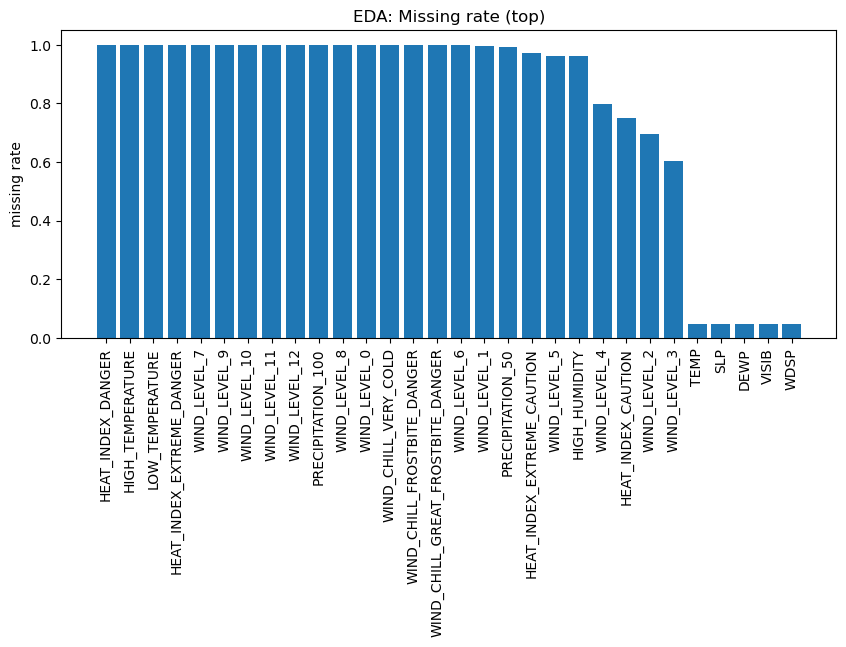

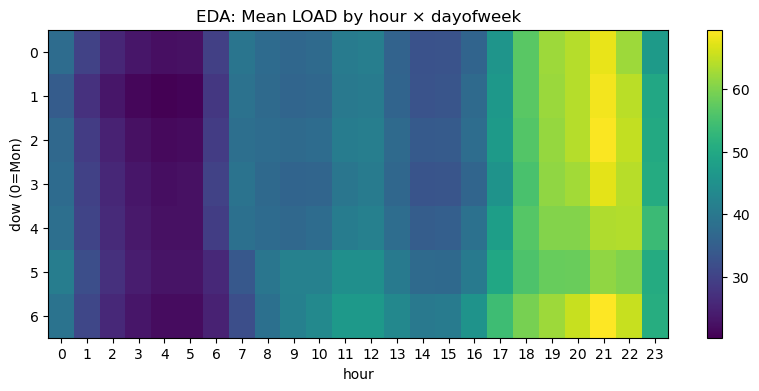

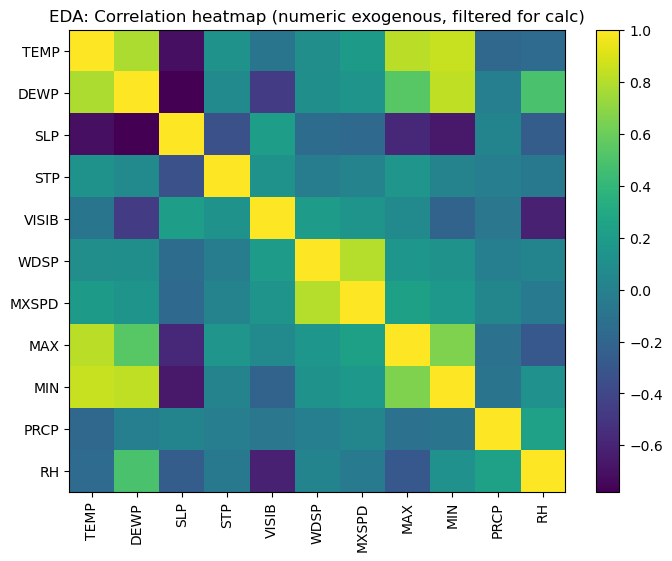

Kept numeric cols (for cond/corr calc): 11 | dropped(high-missing): 11 | dropped(zero-var): 4
Condition number (sampled, standardized numeric exogenous X): 44.62398031167235


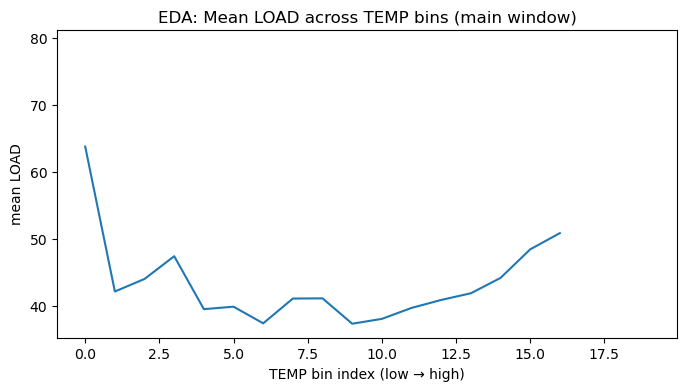

corr(TEMP, LOAD): 0.020823317316619537
corr(TEMP, LOAD_detrended_by_hour): 0.021084798071329167


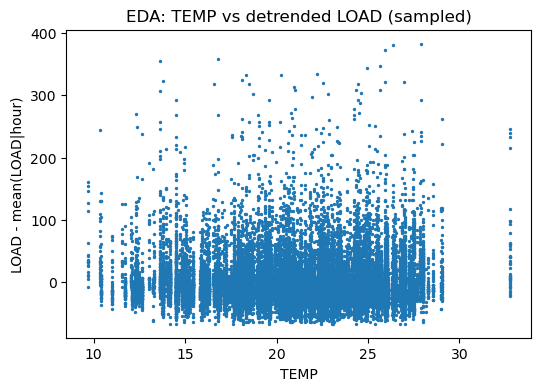

TEMP missing station-date keys merge status:
 _merge
left_only     33
right_only     0
both           0
Name: count, dtype: int64

Top stations by missing TEMP station-date pairs:
 STATION_ID
59211099999    27
59023099999     1
59046099999     1
59254099999     1
59265099999     1
59632099999     1
59644099999     1
dtype: int64


In [6]:
eda_all = EDAAllInOne(df_base_2023, weather_clean, ext_clean)
artifacts = eda_all.run_all()

### 缺失数据处理策略

In [7]:
def _is_binary_like(series: pd.Series, tol: float = 1e-8) -> bool:
    """
    判断非空取值是否仅来自 {0,1}（允许浮点0/1）
    """
    s = series.dropna()
    if len(s) == 0:
        return False
    vals = pd.unique(s)
    # 过滤非有限值
    vals = np.array([v for v in vals if np.isfinite(v)], dtype=float)
    if len(vals) == 0:
        return False
    # 容忍浮点误差
    return np.all((np.abs(vals - 0) <= tol) | (np.abs(vals - 1) <= tol))

def summarize_numeric_columns(df: pd.DataFrame,
                              cols: list[str],
                              unique_sample_n: int = 10) -> pd.DataFrame:
    """
    返回每列的审计表：
    - missing_rate
    - nonnull_count
    - std_nonnull
    - is_binary_like
    - unique_sample（前N个非空唯一值）
    """
    rows = []
    for c in cols:
        if c not in df.columns:
            continue
        s = df[c]
        miss = float(s.isnull().mean())
        nonnull = s.dropna()
        n_nonnull = int(len(nonnull))
        std = float(nonnull.std()) if n_nonnull >= 2 else 0.0
        is_bin = _is_binary_like(s)
        uniq = pd.unique(nonnull)[:unique_sample_n]
        # 转成可打印的 python 标量
        uniq_list = []
        for v in uniq:
            if isinstance(v, (np.floating, np.integer)):
                uniq_list.append(float(v))
            else:
                uniq_list.append(v)

        rows.append({
            "col": c,
            "missing_rate": miss,
            "nonnull_count": n_nonnull,
            "std_nonnull": std,
            "is_binary_like": is_bin,
            "unique_sample": uniq_list
        })
    out = pd.DataFrame(rows).sort_values(["missing_rate", "nonnull_count"], ascending=[False, True])
    return out

In [8]:
def build_exog_policy(audit_df: pd.DataFrame,
                      miss_drop_thresh: float = 0.95,
                      zero_var_tol: float = 1e-8,
                      binary_missing_as_zero: bool = True) -> dict:
    """
    根据审计表生成策略字典 policy。
    注意：这里只决定“列怎么处理”，不直接改数据。
    """
    policy = {}
    policy.setdefault("binary_fill0_cols", [])
    policy.setdefault("continuous_impute_median_cols", [])
    policy.setdefault("drop_cols", [])
    policy.setdefault("notes", {})

    for _, r in audit_df.iterrows():
        c = r["col"]
        miss = float(r["missing_rate"])
        std = float(r["std_nonnull"])
        is_bin = bool(r["is_binary_like"])
        n_nonnull = int(r["nonnull_count"])

        if n_nonnull == 0:
            policy["drop_cols"].append(c)
            continue

        # 2) 零方差：直接丢
        if std <= zero_var_tol:
            policy["drop_cols"].append(c)
            continue

        # 3) 缺失极高：若是二元事件型，允许 NaN->0；否则丢
        if miss >= miss_drop_thresh:
            if binary_missing_as_zero and is_bin:
                policy["binary_fill0_cols"].append(c)
            else:
                policy["drop_cols"].append(c)
            continue

        # 4) 其余：二元事件型可填0；连续型用训练中位数填补
        if binary_missing_as_zero and is_bin:
            policy["binary_fill0_cols"].append(c)
        else:
            policy["continuous_impute_median_cols"].append(c)

    # 去重（保持顺序）
    def _dedup(lst):
        seen = set()
        out = []
        for x in lst:
            if x not in seen:
                seen.add(x); out.append(x)
        return out

    policy["binary_fill0_cols"] = _dedup(policy["binary_fill0_cols"])
    policy["continuous_impute_median_cols"] = _dedup(policy["continuous_impute_median_cols"])
    policy["drop_cols"] = _dedup(policy["drop_cols"])

    policy["notes"]["miss_drop_thresh"] = miss_drop_thresh
    policy["notes"]["zero_var_tol"] = zero_var_tol
    policy["notes"]["binary_missing_as_zero"] = binary_missing_as_zero
    return policy

In [9]:
# RegressionExperimentAB
# 先用 A/B 两套特征对照，量化“加入时间特征”带来的边际改进；
# 在线性框架内同时比较 OLS 与 Ridge：前者可解释性强，后者用于缓解共线性与提升稳健性；
# 再引入 WLS(FGLS) 检验异方差是否会显著影响拟合效率与 RMSE。


def apply_exog_policy(train_df: pd.DataFrame,
                      val_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      policy: dict,
                      warn_on_large_drop: bool = True):
    train_df = train_df.copy()
    val_df = val_df.copy()
    test_df = test_df.copy()

    drop_cols = [c for c in policy.get("drop_cols", []) if c in train_df.columns]
    bin0_cols = [c for c in policy.get("binary_fill0_cols", []) if c in train_df.columns]
    cont_cols = [c for c in policy.get("continuous_impute_median_cols", []) if c in train_df.columns]

    # 1) drop
    if warn_on_large_drop and len(drop_cols) >= 30:
        warnings.warn(f"将剔除 {len(drop_cols)} 个外生数值列（可能正常：大量极端指标缺失过高）。")

    train_df = train_df.drop(columns=drop_cols, errors="ignore")
    val_df   = val_df.drop(columns=drop_cols, errors="ignore")
    test_df  = test_df.drop(columns=drop_cols, errors="ignore")

    # 2) binary: NaN -> 0
    for df in (train_df, val_df, test_df):
        if len(bin0_cols) > 0:
            df[bin0_cols] = df[bin0_cols].fillna(0.0)

    # 3) continuous: train median -> fill all
    if len(cont_cols) > 0:
        med = train_df[cont_cols].median()
        train_df[cont_cols] = train_df[cont_cols].fillna(med)
        val_df[cont_cols]   = val_df[cont_cols].fillna(med)
        test_df[cont_cols]  = test_df[cont_cols].fillna(med)
    else:
        med = pd.Series(dtype=float)

    artifacts = {
        "drop_cols": drop_cols,
        "binary_fill0_cols": bin0_cols,
        "continuous_impute_median_cols": cont_cols,
        "train_median": med
    }
    return train_df, val_df, test_df, artifacts

In [10]:
class RegressionExperimentAB:
    """
    A/B 对照 + OLS/Ridge/WLS(FGLS) 对照
    - TRANSFORMER_ID one-hot（固定效应）
    - 时间切分 70/15/15
    - 外生数值列：先审计 -> policy -> train-only 应用（剔除/填补）
    - WLS：用训练集 OLS 残差按 transformer 估方差，w=1/var
    """

    def __init__(self, df_base: pd.DataFrame, weather_clean: pd.DataFrame, ext_clean: pd.DataFrame):
        self.df_base = df_base.copy()

        self.numeric_exog_all = (
            weather_clean.select_dtypes(include=["number"]).columns.tolist()
            + ext_clean.select_dtypes(include=["number"]).columns.tolist()
        )

        self.cfg = {
            "window": {"start": "2023-03-06 00:00:00", "end": "2023-04-30 23:00:00"},
            "cat_cols": ["TRANSFORMER_ID", "CITY", "DISTRICT", "CLOSEST_STATION", "HOLIDAY", "HAZARD"],
            "time_cols": ["hour", "dow", "month", "hour_sin", "hour_cos"],
            "policy": {
                "miss_drop_thresh": 0.95,
                "binary_missing_as_zero": True
            },
            "models": {
                "OLS": LinearRegression(),
                "Ridge(alpha=1.0)": Ridge(alpha=1.0),
            }
        }

        self.artifacts = {}
        self.results = []

    def build_df_main(self):
        df = self.df_base.sort_values(["TRANSFORMER_ID", "DATETIME"]).copy()
        df["y_next"] = df.groupby("TRANSFORMER_ID")["LOAD"].shift(-1)
        df = df.dropna(subset=["y_next"]).copy()

        start = pd.Timestamp(self.cfg["window"]["start"])
        end = pd.Timestamp(self.cfg["window"]["end"])
        df = df[(df["DATETIME"] >= start) & (df["DATETIME"] <= end)].copy()

        df["hour"] = df["DATETIME"].dt.hour.astype("int16")
        df["dow"] = df["DATETIME"].dt.dayofweek.astype("int16")
        df["month"] = df["DATETIME"].dt.month.astype("int16")
        df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
        df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

        self.artifacts["df_main"] = df
        return df

    def time_split_701515(self, df: pd.DataFrame):
        t_min, t_max = df["DATETIME"].min(), df["DATETIME"].max()
        t1 = t_min + (t_max - t_min) * 0.70
        t2 = t_min + (t_max - t_min) * 0.85

        train = df[df["DATETIME"] <= t1].copy()
        val   = df[(df["DATETIME"] > t1) & (df["DATETIME"] <= t2)].copy()
        test  = df[df["DATETIME"] > t2].copy()

        self.artifacts.update({"train_raw": train, "val_raw": val, "test_raw": test})
        return train, val, test

    def prepare_exog(self, train_df, val_df, test_df):
        audit = summarize_numeric_columns(train_df, self.numeric_exog_all)
        policy = build_exog_policy(
            audit,
            miss_drop_thresh=self.cfg["policy"]["miss_drop_thresh"],
            binary_missing_as_zero=self.cfg["policy"]["binary_missing_as_zero"]
        )

        train2, val2, test2, clean_art = apply_exog_policy(train_df, val_df, test_df, policy)

        self.artifacts["exog_audit"] = audit
        self.artifacts["exog_policy"] = policy
        self.artifacts["exog_clean_artifacts"] = clean_art

        exog_used = clean_art["binary_fill0_cols"] + clean_art["continuous_impute_median_cols"]
        self.artifacts["exog_used_cols"] = exog_used

        return train2, val2, test2, exog_used

    def _X(self, df, num_cols, cat_cols):
        X_num = df[num_cols].copy() if num_cols else pd.DataFrame(index=df.index)
        X_cat = pd.get_dummies(df[cat_cols].astype(str), prefix=cat_cols) if cat_cols else pd.DataFrame(index=df.index)
        X = pd.concat([X_num, X_cat], axis=1)
    
        return X.astype(np.float32, copy=False)    # 注意需要降低占用内存数量，使用32


    @staticmethod
    def _metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = float(np.sqrt(mse))
        mae = float(np.mean(np.abs(y_true - y_pred)))
        return {"MSE": float(mse), "RMSE": rmse, "MAE": mae}

    def _run_one_setting(self, setting_name: str, num_cols: list[str], train_df, val_df, test_df):
        cat_cols = self.cfg["cat_cols"]

        Xtr = self._X(train_df, num_cols, cat_cols)
        Xva = self._X(val_df,   num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)
        Xte = self._X(test_df,  num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)

        ytr = train_df["y_next"].values
        yva = val_df["y_next"].values
        yte = test_df["y_next"].values

        # OLS / Ridge
        for model_name, model in self.cfg["models"].items():
            model.fit(Xtr, ytr)
            pva = model.predict(Xva)
            pte = model.predict(Xte)

            row = {"Setting": setting_name, "Model": model_name}
            row.update({f"VAL_{k}": v for k, v in self._metrics(yva, pva).items()})
            row.update({f"TEST_{k}": v for k, v in self._metrics(yte, pte).items()})
            self.results.append(row)

        # WLS(FGLS)：训练集 OLS 残差 -> transformer 方差权重
        ols = LinearRegression()
        ols.fit(Xtr, ytr)
        resid = ytr - ols.predict(Xtr)

        resid_df = pd.DataFrame({"TRANSFORMER_ID": train_df["TRANSFORMER_ID"].values, "resid": resid})
        var_by_id = resid_df.groupby("TRANSFORMER_ID")["resid"].agg(lambda s: float(np.var(s)) + 1e-8)
        w = 1.0 / train_df["TRANSFORMER_ID"].map(var_by_id).astype(float).values

        wls = LinearRegression()
        wls.fit(Xtr, ytr, sample_weight=w)
        pva = wls.predict(Xva)
        pte = wls.predict(Xte)

        row = {"Setting": setting_name, "Model": "WLS(FGLS via transformer var)"}
        row.update({f"VAL_{k}": v for k, v in self._metrics(yva, pva).items()})
        row.update({f"TEST_{k}": v for k, v in self._metrics(yte, pte).items()})
        self.results.append(row)

    def run(self):
        df_main = self.build_df_main()
        train_df, val_df, test_df = self.time_split_701515(df_main)
        train2, val2, test2, exog_used = self.prepare_exog(train_df, val_df, test_df)

        feature_sets = {
            "A (exogenous only)": {
                "num": exog_used
            },
            "B (A + time features)": {
                "num": exog_used + self.cfg["time_cols"]
            }
        }
        self.artifacts["feature_sets"] = feature_sets

        for setting, fs in feature_sets.items():
            self._run_one_setting(setting, fs["num"], train2, val2, test2)

        return pd.DataFrame(self.results)

In [11]:
exp = RegressionExperimentAB(df_base_2023, weather_clean, ext_clean)
res_df = exp.run()

print(res_df.sort_values(["Setting", "Model"]))

clean_art = exp.artifacts["exog_clean_artifacts"]
print("\nExog handling summary:")
print("  drop_cols:", len(clean_art["drop_cols"]))
print("  binary_fill0_cols:", len(clean_art["binary_fill0_cols"]))
print("  continuous_impute_median_cols:", len(clean_art["continuous_impute_median_cols"]))
print("  exog_used_cols:", len(exp.artifacts["exog_used_cols"]))


# 这里的结果说明会出现严重的多重共线性

                 Setting                          Model      VAL_MSE  \
0     A (exogenous only)                            OLS  1771.306832   
1     A (exogenous only)               Ridge(alpha=1.0)   509.529587   
2     A (exogenous only)  WLS(FGLS via transformer var)  2800.131705   
3  B (A + time features)                            OLS  1668.813248   
4  B (A + time features)               Ridge(alpha=1.0)   397.372999   
5  B (A + time features)  WLS(FGLS via transformer var)  1925.694335   

    VAL_RMSE    VAL_MAE     TEST_MSE  TEST_RMSE   TEST_MAE  
0  42.086896  27.532010  1594.413415  39.930107  26.429134  
1  22.572762  13.281342   479.875760  21.906067  13.248361  
2  52.916271  33.414901  2450.451717  49.502037  30.532619  
3  40.851111  26.365151  1504.171930  38.783655  25.493049  
4  19.934217  12.409663   384.913488  19.619212  12.672592  
5  43.882734  26.350962  1723.072971  41.509914  24.820646  

Exog handling summary:
  drop_cols: 15
  binary_fill0_cols: 0
  con

### 调参过程

In [12]:
class RegressionExperimentABC(RegressionExperimentAB):
    """
    ABC 对照 + OLS/Ridge/WLS(FGLS) 对照
    - A: 外生数值 + 类别 one-hot（含 TRANSFORMER_ID）
    - B: A + 时间特征
    - C: B + lag/rolling
    - 外生数值：训练集审计 -> policy -> train-only 应用（剔除/填补）
    - WLS：训练集 OLS 残差按 transformer 估方差，w=1/var
    - 调参：
        * Ridge: alpha 网格，VAL_RMSE 选最优
        * WLS: 权重分位数裁剪 clip，VAL_RMSE 选最优
    """

    def __init__(self, df_base: pd.DataFrame, weather_clean: pd.DataFrame, ext_clean: pd.DataFrame):
        super().__init__(df_base, weather_clean, ext_clean)

        self.cfg["lag_cols"] = ["lag_1", "lag_24", "lag_168"]
        self.cfg["roll_cols"] = ["roll_mean_24", "roll_mean_168"]
        self.cfg["compare_on_c_ready"] = True

    def build_df_main(self):
        df = self.df_base.sort_values(["TRANSFORMER_ID", "DATETIME"]).copy()
        g = df.groupby("TRANSFORMER_ID")["LOAD"]

        # lag
        df["lag_1"] = g.shift(1)
        df["lag_24"] = g.shift(24)
        df["lag_168"] = g.shift(168)

        s1 = g.shift(1)
        df["roll_mean_24"] = (
            s1.groupby(df["TRANSFORMER_ID"])
              .rolling(24, min_periods=24).mean()
              .reset_index(level=0, drop=True)
        )
        df["roll_mean_168"] = (
            s1.groupby(df["TRANSFORMER_ID"])
              .rolling(168, min_periods=168).mean()
              .reset_index(level=0, drop=True)
        )

        df["y_next"] = g.shift(-1)

        start = pd.Timestamp(self.cfg["window"]["start"])
        end = pd.Timestamp(self.cfg["window"]["end"])
        df = df[(df["DATETIME"] >= start) & (df["DATETIME"] <= end)].copy()

        df["hour"] = df["DATETIME"].dt.hour.astype("int16")
        df["dow"] = df["DATETIME"].dt.dayofweek.astype("int16")
        df["month"] = df["DATETIME"].dt.month.astype("int16")
        df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
        df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

        df = df.dropna(subset=["y_next"]).copy()
        self.artifacts["df_main"] = df
        return df

    def run(self):
        df_main = self.build_df_main()

        if self.cfg.get("compare_on_c_ready", True):
            need = self.cfg["lag_cols"] + self.cfg["roll_cols"]
            before = len(df_main)
            df_main = df_main.dropna(subset=need).copy()
            self.artifacts["c_ready_rows_before"] = before
            self.artifacts["c_ready_rows_after"] = len(df_main)

        train_df, val_df, test_df = self.time_split_701515(df_main)
        train2, val2, test2, exog_used = self.prepare_exog(train_df, val_df, test_df)

        ar_cols = self.cfg["lag_cols"] + self.cfg["roll_cols"]
        feature_sets = {
            "A (exogenous only)": {"num": exog_used},
            "B (A + time features)": {"num": exog_used + self.cfg["time_cols"]},
            "C (B + lag/rolling)": {"num": exog_used + self.cfg["time_cols"] + ar_cols},
        }
        self.artifacts["feature_sets"] = feature_sets

        self.results = []
        for setting, fs in feature_sets.items():
            self._run_one_setting(setting, fs["num"], train2, val2, test2)

        return pd.DataFrame(self.results)

    def tune_ridge_alpha(self,
                         setting_name="C (B + lag/rolling)",
                         alphas=(0.01, 0.1, 1.0, 10.0, 100.0, 1000.0)):
        df_main = self.build_df_main()

        if self.cfg.get("compare_on_c_ready", True):
            need = self.cfg["lag_cols"] + self.cfg["roll_cols"]
            df_main = df_main.dropna(subset=need).copy()

        train_df, val_df, test_df = self.time_split_701515(df_main)
        train2, val2, test2, exog_used = self.prepare_exog(train_df, val_df, test_df)

        ar_cols = self.cfg["lag_cols"] + self.cfg["roll_cols"]
        feature_map = {
            "A (exogenous only)": exog_used,
            "B (A + time features)": exog_used + self.cfg["time_cols"],
            "C (B + lag/rolling)": exog_used + self.cfg["time_cols"] + ar_cols,
        }
        if setting_name not in feature_map:
            raise ValueError(f"Unknown setting_name: {setting_name}")

        num_cols = feature_map[setting_name]
        cat_cols = self.cfg["cat_cols"]

        Xtr = self._X(train2, num_cols, cat_cols)
        Xva = self._X(val2,   num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)
        Xte = self._X(test2,  num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)

        ytr = train2["y_next"].values
        yva = val2["y_next"].values
        yte = test2["y_next"].values

        rows = []
        for a in alphas:
            model = Ridge(alpha=float(a))
            model.fit(Xtr, ytr)

            pva = model.predict(Xva)
            pte = model.predict(Xte)

            row = {"Setting": setting_name, "Model": "Ridge", "alpha": float(a)}
            row.update({f"VAL_{k}": v for k, v in self._metrics(yva, pva).items()})
            row.update({f"TEST_{k}": v for k, v in self._metrics(yte, pte).items()})
            rows.append(row)

        tune_df = pd.DataFrame(rows).sort_values(["VAL_RMSE", "alpha"])
        best = tune_df.iloc[0].to_dict()

        self.artifacts["ridge_tuning_table"] = tune_df
        self.artifacts["ridge_best"] = best

        print("Best alpha by VAL_RMSE:", best["alpha"])
        print("Best VAL_RMSE:", best["VAL_RMSE"], "| TEST_RMSE:", best["TEST_RMSE"], "| TEST_MAE:", best["TEST_MAE"])
        return tune_df

    def tune_wls_clip(self,
                      setting_name="C (B + lag/rolling)",
                      clip_pairs=((0.0, 1.0),
                                  (0.001, 0.999),
                                  (0.01, 0.99),
                                  (0.05, 0.95),
                                  (0.1, 0.9))):
        df_main = self.build_df_main()

        if self.cfg.get("compare_on_c_ready", True):
            need = self.cfg["lag_cols"] + self.cfg["roll_cols"]
            df_main = df_main.dropna(subset=need).copy()

        train_df, val_df, test_df = self.time_split_701515(df_main)
        train2, val2, test2, exog_used = self.prepare_exog(train_df, val_df, test_df)

        ar_cols = self.cfg["lag_cols"] + self.cfg["roll_cols"]
        feature_map = {
            "A (exogenous only)": exog_used,
            "B (A + time features)": exog_used + self.cfg["time_cols"],
            "C (B + lag/rolling)": exog_used + self.cfg["time_cols"] + ar_cols,
        }
        if setting_name not in feature_map:
            raise ValueError(f"Unknown setting_name: {setting_name}")

        num_cols = feature_map[setting_name]
        cat_cols = self.cfg["cat_cols"]

        Xtr = self._X(train2, num_cols, cat_cols)
        Xva = self._X(val2,   num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)
        Xte = self._X(test2,  num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)

        ytr = train2["y_next"].values
        yva = val2["y_next"].values
        yte = test2["y_next"].values

        # WLS：训练集 OLS 残差估方差
        ols = LinearRegression()
        ols.fit(Xtr, ytr)
        resid = ytr - ols.predict(Xtr)

        resid_df = pd.DataFrame({"TRANSFORMER_ID": train2["TRANSFORMER_ID"].values, "resid": resid})
        var_by_id = resid_df.groupby("TRANSFORMER_ID")["resid"].agg(lambda s: float(np.var(s)) + 1e-8)

        w_raw = 1.0 / train2["TRANSFORMER_ID"].map(var_by_id).astype(float).values

        # 保存权重分布摘要（报告可用）
        self.artifacts["wls_w_raw_summary"] = {
            "min": float(np.min(w_raw)),
            "p01": float(np.quantile(w_raw, 0.01)),
            "p50": float(np.quantile(w_raw, 0.50)),
            "p99": float(np.quantile(w_raw, 0.99)),
            "max": float(np.max(w_raw)),
        }

        rows = []
        for (ql, qh) in clip_pairs:
            ql = float(ql); qh = float(qh)
            if not (0.0 <= ql <= qh <= 1.0):
                raise ValueError(f"Invalid clip pair: {(ql, qh)}")

            lo = float(np.quantile(w_raw, ql))
            hi = float(np.quantile(w_raw, qh))
            w = np.clip(w_raw, lo, hi)

            wls = LinearRegression()
            wls.fit(Xtr, ytr, sample_weight=w)

            pva = wls.predict(Xva)
            pte = wls.predict(Xte)

            row = {"Setting": setting_name, "Model": "WLS(FGLS)", "clip_low_q": ql, "clip_high_q": qh,
                   "w_clip_low": lo, "w_clip_high": hi}
            row.update({f"VAL_{k}": v for k, v in self._metrics(yva, pva).items()})
            row.update({f"TEST_{k}": v for k, v in self._metrics(yte, pte).items()})
            rows.append(row)

        tune_df = pd.DataFrame(rows).sort_values(["VAL_RMSE", "clip_low_q", "clip_high_q"])
        best = tune_df.iloc[0].to_dict()

        self.artifacts["wls_clip_tuning_table"] = tune_df
        self.artifacts["wls_clip_best"] = best

        print("Best clip by VAL_RMSE:",
              (best["clip_low_q"], best["clip_high_q"]),
              "| w in [", best["w_clip_low"], ",", best["w_clip_high"], "]")
        print("Best VAL_RMSE:", best["VAL_RMSE"], "| TEST_RMSE:", best["TEST_RMSE"], "| TEST_MAE:", best["TEST_MAE"])
        return tune_df

In [13]:
expC = RegressionExperimentABC(df_base_2023, weather_clean, ext_clean)

In [14]:
# 运行 A/B/C 线性基线对照（OLS / Ridge / WLS）

res_abc = expC.run()

# 捕获异常
try:
    display(res_abc.sort_values(["Setting", "Model"]))
except NameError:
    print(res_abc.sort_values(["Setting", "Model"]))

print("C-ready rows:", expC.artifacts["c_ready_rows_before"], "->", expC.artifacts["c_ready_rows_after"])


,Setting,Model,VAL_MSE,VAL_RMSE,VAL_MAE,TEST_MSE,TEST_RMSE,TEST_MAE
0,A (exogenous only),OLS,2521.446814,50.214010,27.502843,1248.282546,35.331042,23.000294
1,A (exogenous only),Ridge(alpha=1.0),561.502270,23.696039,15.649411,370.993926,19.261203,13.542355
2,A (exogenous only),WLS(FGLS via transformer var),4240.252506,65.117221,41.023972,1909.802120,43.701283,25.934858
3,B (A + time features),OLS,2355.943401,48.538061,25.809175,1182.916239,34.393549,22.362524
4,B (A + time features),Ridge(alpha=1.0),408.069845,20.200739,12.840312,328.273643,18.118323,13.276452
5,B (A + time features),WLS(FGLS via transformer var),2866.736245,53.541911,28.250913,1281.416905,35.796884,20.739797
6,C (B + lag/rolling),OLS,244.249812,15.628494,8.409863,223.601922,14.953325,10.202213
7,C (B + lag/rolling),Ridge(alpha=1.0),241.800388,15.549932,8.749488,239.175039,15.465285,10.944322
8,C (B + lag/rolling),WLS(FGLS via transformer var),225.855738,15.028498,8.255076,190.360843,13.797132,9.290142


C-ready rows: 478269 -> 147873


In [15]:
tune_df = expC.tune_ridge_alpha(
    setting_name="C (B + lag/rolling)",
    alphas=(0.01, 0.1, 1, 10, 100, 1000)
)
tune_wls_df = expC.tune_wls_clip(
    setting_name="C (B + lag/rolling)",
    clip_pairs=((0,1),(0.001,0.999),(0.01,0.99),(0.05,0.95),(0.1,0.9))
)

print("\n===== Ridge alpha tuning table (sorted by VAL_RMSE) =====")
print(tune_df)

print("\n===== WLS weight-clip tuning table (sorted by VAL_RMSE) =====")
print(tune_wls_df)

ridge_best = tune_df.sort_values(["VAL_RMSE", "alpha"]).iloc[0].copy()
wls_best   = tune_wls_df.sort_values(["VAL_RMSE", "clip_low_q", "clip_high_q"]).iloc[0].copy()

def _pick_row(df, cond):
    sub = df[cond].copy()
    if len(sub) == 0:
        return None
    return sub.iloc[0]

ridge_base = _pick_row(tune_df, np.isclose(tune_df["alpha"].astype(float), 1.0))
wls_base = _pick_row(
    tune_wls_df,
    np.isclose(tune_wls_df["clip_low_q"].astype(float), 0.0) & np.isclose(tune_wls_df["clip_high_q"].astype(float), 1.0)
)

def _summary_row(name, row):
    return {
        "Tuning": name,
        "VAL_RMSE": float(row["VAL_RMSE"]),
        "VAL_MAE": float(row["VAL_MAE"]),
        "TEST_RMSE": float(row["TEST_RMSE"]),
        "TEST_MAE": float(row["TEST_MAE"]),
        "params": (
            f"alpha={row['alpha']}" if "alpha" in row.index
            else f"clip=({row['clip_low_q']},{row['clip_high_q']})"
        )
    }

rows = []
rows.append(_summary_row("Ridge-best", ridge_best))
if ridge_base is not None:
    rows.append(_summary_row("Ridge-baseline(alpha=1)", ridge_base))

rows.append(_summary_row("WLS-best(clip)", wls_best))
if wls_base is not None:
    rows.append(_summary_row("WLS-baseline(clip=(0,1))", wls_base))

summary = pd.DataFrame(rows)

# 计算相对“各自 baseline”的提升（RMSE/MAE）
def _improve(best, base, metric):
    if base is None:
        return np.nan
    return float(base[metric] - best[metric])

def _improve_pct(best, base, metric):
    if base is None:
        return np.nan
    b = float(base[metric])
    return float((b - float(best[metric])) / b * 100.0) if b != 0 else np.nan

# 增加两组 improvement 列
if ridge_base is not None:
    summary.loc[summary["Tuning"]=="Ridge-best", "ΔVAL_RMSE_vs_base"] = _improve(ridge_best, ridge_base, "VAL_RMSE")
    summary.loc[summary["Tuning"]=="Ridge-best", "ΔTEST_RMSE_vs_base"] = _improve(ridge_best, ridge_base, "TEST_RMSE")
    summary.loc[summary["Tuning"]=="Ridge-best", "%TEST_RMSE_vs_base"] = _improve_pct(ridge_best, ridge_base, "TEST_RMSE")

if wls_base is not None:
    summary.loc[summary["Tuning"]=="WLS-best(clip)", "ΔVAL_RMSE_vs_base"] = _improve(wls_best, wls_base, "VAL_RMSE")
    summary.loc[summary["Tuning"]=="WLS-best(clip)", "ΔTEST_RMSE_vs_base"] = _improve(wls_best, wls_base, "TEST_RMSE")
    summary.loc[summary["Tuning"]=="WLS-best(clip)", "%TEST_RMSE_vs_base"] = _improve_pct(wls_best, wls_base, "TEST_RMSE")

print("\n===== Tuning summary (best vs baseline) =====")
print(summary)


final_pick = summary.sort_values(["VAL_RMSE"]).iloc[0]
print("\n===== Final pick by VAL_RMSE (recommended for report) =====")
print(final_pick.to_dict())

Best alpha by VAL_RMSE: 0.1
Best VAL_RMSE: 15.544692820135388 | TEST_RMSE: 15.600410439372993 | TEST_MAE: 11.15192259143825
Best clip by VAL_RMSE: (0.001, 0.999) | w in [ 0.0006442888121218429 , 0.2830856909345296 ]
Best VAL_RMSE: 15.028496731658665 | TEST_RMSE: 13.79711459580133 | TEST_MAE: 9.290134295191239

===== Ridge alpha tuning table (sorted by VAL_RMSE) =====
               Setting  Model    alpha     VAL_MSE   VAL_RMSE   VAL_MAE  \
1  C (B + lag/rolling)  Ridge     0.10  241.637475  15.544693  8.751993   
0  C (B + lag/rolling)  Ridge     0.01  241.663065  15.545516  8.742815   
2  C (B + lag/rolling)  Ridge     1.00  241.800388  15.549932  8.749488   
3  C (B + lag/rolling)  Ridge    10.00  242.653423  15.577337  8.786844   
5  C (B + lag/rolling)  Ridge  1000.00  242.817323  15.582597  8.769760   
4  C (B + lag/rolling)  Ridge   100.00  243.095144  15.591509  8.802919   

     TEST_MSE  TEST_RMSE   TEST_MAE  
1  243.372806  15.600410  11.151923  
0  243.523481  15.605239  11

In [16]:
base = res_abc.copy()

ridge_best = tune_df.sort_values(["VAL_RMSE", "alpha"]).iloc[0].copy()
wls_best = tune_wls_df.sort_values(["VAL_RMSE", "clip_low_q", "clip_high_q"]).iloc[0].copy()

tuned_rows = pd.DataFrame([
    {
        "Setting": ridge_best["Setting"],
        "Model": f"Ridge-tuned(alpha={ridge_best['alpha']})",
        "VAL_MSE": ridge_best["VAL_MSE"], "VAL_RMSE": ridge_best["VAL_RMSE"], "VAL_MAE": ridge_best["VAL_MAE"],
        "TEST_MSE": ridge_best["TEST_MSE"], "TEST_RMSE": ridge_best["TEST_RMSE"], "TEST_MAE": ridge_best["TEST_MAE"]
    },
    {
        "Setting": wls_best["Setting"],
        "Model": f"WLS-tuned(clip=({wls_best['clip_low_q']},{wls_best['clip_high_q']}))",
        "VAL_MSE": wls_best["VAL_MSE"], "VAL_RMSE": wls_best["VAL_RMSE"], "VAL_MAE": wls_best["VAL_MAE"],
        "TEST_MSE": wls_best["TEST_MSE"], "TEST_RMSE": wls_best["TEST_RMSE"], "TEST_MAE": wls_best["TEST_MAE"]
    },
])

final_table = pd.concat([base, tuned_rows], ignore_index=True)
final_table = final_table.sort_values(["Setting", "Model"])
print("===== Final leaderboard (base + tuned) =====")
print(final_table)

def pick_min(df, setting):
    sub = df[df["Setting"] == setting].copy()
    return sub.sort_values("TEST_RMSE").iloc[0]

A_best = pick_min(final_table, "A (exogenous only)")
B_best = pick_min(final_table, "B (A + time features)")
C_best = pick_min(final_table, "C (B + lag/rolling)")

gain = pd.DataFrame([
    {"From": "A→B", "TEST_RMSE_drop": A_best["TEST_RMSE"] - B_best["TEST_RMSE"],
     "TEST_RMSE_drop_%": (A_best["TEST_RMSE"] - B_best["TEST_RMSE"]) / A_best["TEST_RMSE"] * 100},
    {"From": "B→C", "TEST_RMSE_drop": B_best["TEST_RMSE"] - C_best["TEST_RMSE"],
     "TEST_RMSE_drop_%": (B_best["TEST_RMSE"] - C_best["TEST_RMSE"]) / B_best["TEST_RMSE"] * 100},
])

print("\n===== Gains (best model within each setting) =====")
print(gain)

print("\n===== Best per setting (by TEST_RMSE) =====")
print(pd.DataFrame([A_best, B_best, C_best])[["Setting","Model","VAL_RMSE","TEST_RMSE","TEST_MAE"]])

===== Final leaderboard (base + tuned) =====
                  Setting                          Model      VAL_MSE  \
0      A (exogenous only)                            OLS  2521.446814   
1      A (exogenous only)               Ridge(alpha=1.0)   561.502270   
2      A (exogenous only)  WLS(FGLS via transformer var)  4240.252506   
3   B (A + time features)                            OLS  2355.943401   
4   B (A + time features)               Ridge(alpha=1.0)   408.069845   
5   B (A + time features)  WLS(FGLS via transformer var)  2866.736245   
6     C (B + lag/rolling)                            OLS   244.249812   
7     C (B + lag/rolling)               Ridge(alpha=1.0)   241.800388   
9     C (B + lag/rolling)         Ridge-tuned(alpha=0.1)   241.637475   
8     C (B + lag/rolling)  WLS(FGLS via transformer var)   225.855738   
10    C (B + lag/rolling)  WLS-tuned(clip=(0.001,0.999))   225.855714   

     VAL_RMSE    VAL_MAE     TEST_MSE  TEST_RMSE   TEST_MAE  
0   50.214010  2

## 残差诊断

本节从两个维度刻画误差结构，以辅助解释“为何某些模型/特征设定更优”：
1. **异方差**：考察 \(|e|\) 随 \(\hat{y}\) 的变化关系（漏斗形/扇形扩散为典型信号）。  
2. **时段系统性偏差**：按 \(dow\times hour\) 聚合残差均值，识别持续的高估/低估时段（结构性 bias）。


In [17]:
class ResidualDiagnostics:
    """
    残差诊断（不包含 transformer 残差方差分布部分）：
    1) |resid| vs y_pred：异方差直观检验（OLS vs WLS）
    2) hour×dow 残差均值热力图：系统性遗漏模式（OLS vs WLS）
    3) 文本 summary：resid_mean/std、abs_resid_mean、corr(pred,|resid|)
    4) WLS 权重裁剪范围摘要（TRAIN）
    """

    def __init__(self, exp, setting_name="C (B + lag/rolling)",
                 wls_clip=(0.001, 0.999), sample_scatter=60000, random_state=42):
        self.exp = exp
        self.setting_name = setting_name
        self.wls_clip = tuple(wls_clip)
        self.sample_scatter = int(sample_scatter)
        self.random_state = int(random_state)
        self.artifacts = {}

    def _prepare_split_and_exog(self):
        df_main = self.exp.build_df_main()

        if self.exp.cfg.get("compare_on_c_ready", True):
            need = self.exp.cfg["lag_cols"] + self.exp.cfg["roll_cols"]
            df_main = df_main.dropna(subset=need).copy()

        train_df, val_df, test_df = self.exp.time_split_701515(df_main)
        train2, val2, test2, exog_used = self.exp.prepare_exog(train_df, val_df, test_df)

        self.artifacts["exog_used"] = exog_used
        self.artifacts["splits"] = {"train": train2, "val": val2, "test": test2}
        return train2, val2, test2, exog_used

    def _num_cols_for_setting(self, exog_used):
        ar_cols = self.exp.cfg["lag_cols"] + self.exp.cfg["roll_cols"]
        mapping = {
            "A (exogenous only)": exog_used,
            "B (A + time features)": exog_used + self.exp.cfg["time_cols"],
            "C (B + lag/rolling)": exog_used + self.exp.cfg["time_cols"] + ar_cols,
        }
        if self.setting_name not in mapping:
            raise ValueError(f"Unknown setting_name: {self.setting_name}")
        return mapping[self.setting_name]

    def _fit_predict_ols_wls(self, train2, test2, num_cols):
        cat_cols = self.exp.cfg["cat_cols"]

        Xtr = self.exp._X(train2, num_cols, cat_cols)
        Xte = self.exp._X(test2,  num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)

        ytr = train2["y_next"].values
        yte = test2["y_next"].values

        # OLS
        ols = LinearRegression()
        ols.fit(Xtr, ytr)
        pred_tr_ols = ols.predict(Xtr)
        pred_te_ols = ols.predict(Xte)

        # WLS
        resid_tr = ytr - pred_tr_ols
        resid_df = pd.DataFrame({"TRANSFORMER_ID": train2["TRANSFORMER_ID"].values, "resid": resid_tr})
        var_by_id = resid_df.groupby("TRANSFORMER_ID")["resid"].agg(lambda s: float(np.var(s)) + 1e-8)

        w_raw = 1.0 / train2["TRANSFORMER_ID"].map(var_by_id).astype(float).values

        ql, qh = self.wls_clip
        lo = float(np.quantile(w_raw, ql))
        hi = float(np.quantile(w_raw, qh))
        w = np.clip(w_raw, lo, hi)

        self.artifacts["wls_weight_summary"] = {
            "clip": self.wls_clip,
            "w_clip_low": lo,
            "w_clip_high": hi,
            "w_min": float(w.min()),
            "w_p50": float(np.quantile(w, 0.50)),
            "w_max": float(w.max()),
        }

        # WLS 拟合
        wls = LinearRegression()
        wls.fit(Xtr, ytr, sample_weight=w)
        pred_te_wls = wls.predict(Xte)

        out = test2[["DATETIME", "TRANSFORMER_ID", "hour", "dow", "y_next"]].copy()
        out["pred_ols"] = pred_te_ols
        out["pred_wls"] = pred_te_wls
        out["resid_ols"] = out["y_next"] - out["pred_ols"]
        out["resid_wls"] = out["y_next"] - out["pred_wls"]
        out["abs_resid_ols"] = out["resid_ols"].abs()
        out["abs_resid_wls"] = out["resid_wls"].abs()
        return out

    def plot_abs_resid_vs_pred(self, diag_df):
        df = diag_df.copy()
        if len(df) > self.sample_scatter:
            df = df.sample(self.sample_scatter, random_state=self.random_state)

        fig, ax = plt.subplots()
        ax.scatter(df["pred_ols"], df["abs_resid_ols"], s=5)
        ax.set_title("Residual diag: |resid| vs y_pred (OLS, sampled)")
        ax.set_xlabel("y_pred (OLS)")
        ax.set_ylabel("|resid| (OLS)")
        plt.show()

        fig, ax = plt.subplots()
        ax.scatter(df["pred_wls"], df["abs_resid_wls"], s=5)
        ax.set_title("Residual diag: |resid| vs y_pred (WLS, sampled)")
        ax.set_xlabel("y_pred (WLS)")
        ax.set_ylabel("|resid| (WLS)")
        plt.show()

    def plot_resid_heatmap(self, diag_df):
        piv_ols = diag_df.pivot_table(index="dow", columns="hour", values="resid_ols", aggfunc="mean")
        fig, ax = plt.subplots()
        im = ax.imshow(piv_ols.values)
        ax.set_title("Residual mean heatmap (OLS): dow × hour")
        ax.set_xlabel("hour")
        ax.set_ylabel("dow (0=Mon)")
        plt.colorbar(im)
        plt.show()

        piv_wls = diag_df.pivot_table(index="dow", columns="hour", values="resid_wls", aggfunc="mean")
        fig, ax = plt.subplots()
        im = ax.imshow(piv_wls.values)
        ax.set_title("Residual mean heatmap (WLS): dow × hour")
        ax.set_xlabel("hour")
        ax.set_ylabel("dow (0=Mon)")
        plt.colorbar(im)
        plt.show()

    def summarize(self, diag_df):
        corr_ols = float(diag_df[["pred_ols", "abs_resid_ols"]].corr().iloc[0, 1])
        corr_wls = float(diag_df[["pred_wls", "abs_resid_wls"]].corr().iloc[0, 1])

        s = {}
        for name in ["ols", "wls"]:
            r = diag_df[f"resid_{name}"]
            s[f"{name}_resid_mean"] = float(r.mean())
            s[f"{name}_resid_std"] = float(r.std())
            s[f"{name}_abs_resid_mean"] = float(r.abs().mean())

        s["corr(pred, |resid|)_OLS"] = corr_ols
        s["corr(pred, |resid|)_WLS"] = corr_wls

        self.artifacts["summary"] = s

        print("===== Residual diagnostics summary (TEST) =====")
        for k, v in s.items():
            print(f"{k}: {v}")

        print("\n===== WLS weight summary (TRAIN) =====")
        print(self.artifacts.get("wls_weight_summary", {}))

    def run(self):
        train2, val2, test2, exog_used = self._prepare_split_and_exog()
        num_cols = self._num_cols_for_setting(exog_used)

        diag_df = self._fit_predict_ols_wls(train2, test2, num_cols)
        self.artifacts["diag_df"] = diag_df

        self.plot_abs_resid_vs_pred(diag_df)
        self.plot_resid_heatmap(diag_df)
        self.summarize(diag_df)

        return diag_df

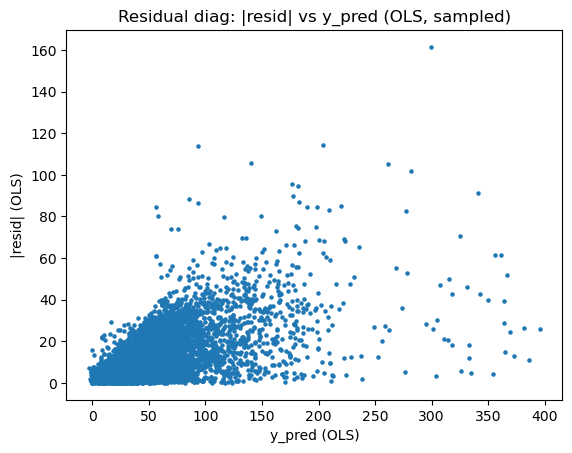

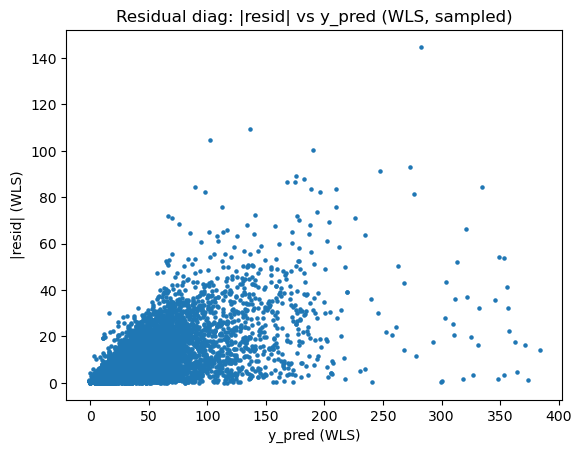

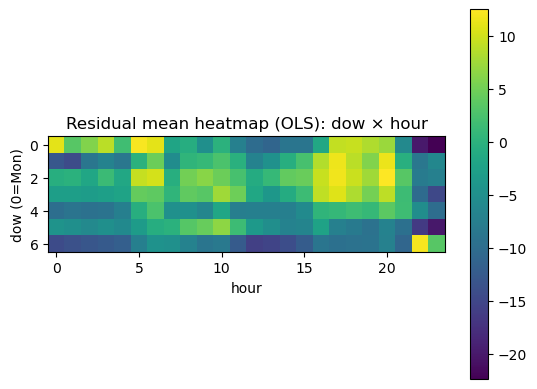

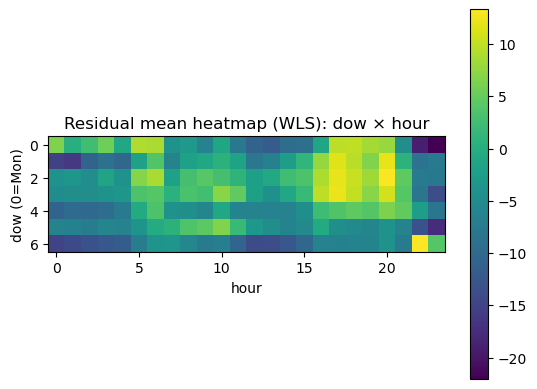

===== Residual diagnostics summary (TEST) =====
ols_resid_mean: -6.595719839093969
ols_resid_std: 13.420767671744922
ols_abs_resid_mean: 10.202212680947811
wls_resid_mean: -5.522314110147425
wls_resid_std: 12.644403159178786
wls_abs_resid_mean: 9.290134295191239
corr(pred, |resid|)_OLS: 0.6169616663891268
corr(pred, |resid|)_WLS: 0.5950137100258261

===== WLS weight summary (TRAIN) =====
{'clip': (0.001, 0.999), 'w_clip_low': 0.0006442888121218429, 'w_clip_high': 0.2830856909345296, 'w_min': 0.0006442888121218429, 'w_p50': 0.014543464971934322, 'w_max': 0.2830856909345296}


In [18]:
diag = ResidualDiagnostics(expC, setting_name="C (B + lag/rolling)", wls_clip=(0.001, 0.999))
diag_df = diag.run()

## 机器学习模型实验（HGBR / MLP）

在特征集 C 的基础上，引入更强的非线性拟合能力以吸收：
温度与负荷的阈值/分段关系；  
时段 × 天气 × 滞后信息的高阶交互；  
尖峰区间的非对称误差结构。

调参准则：以验证集 RMSE 最小选择超参（避免“测试集选参”带来的偏差）。


In [19]:
class MLExperimentD:
    """
    D 环节：机器学习/神经网络预测（以 setting=C 为主）
    - 复用 expC 的数据链：build_df_main -> (C-ready) -> time_split_701515 -> prepare_exog -> expC._X
    - 统一评估：VAL/TEST 的 MSE/RMSE/MAE
    - 支持手写网格调参（避免 time-series 下 CV 泄漏）
    """

    def __init__(self, expC, setting_name="C (B + lag/rolling)", random_state=42):
        self.exp = expC
        self.setting_name = setting_name
        self.random_state = int(random_state)
        self.artifacts = {}

    def _metrics(self, y_true, y_pred):
        mse = float(mean_squared_error(y_true, y_pred))
        rmse = float(np.sqrt(mse))
        mae = float(mean_absolute_error(y_true, y_pred))
        return {"MSE": mse, "RMSE": rmse, "MAE": mae}

    def _prepare(self):
        df_main = self.exp.build_df_main()

        if self.exp.cfg.get("compare_on_c_ready", True):
            need = self.exp.cfg["lag_cols"] + self.exp.cfg["roll_cols"]
            df_main = df_main.dropna(subset=need).copy()

        train_df, val_df, test_df = self.exp.time_split_701515(df_main)
        train2, val2, test2, exog_used = self.exp.prepare_exog(train_df, val_df, test_df)

        # feature set map
        ar_cols = self.exp.cfg["lag_cols"] + self.exp.cfg["roll_cols"]
        feature_map = {
            "A (exogenous only)": exog_used,
            "B (A + time features)": exog_used + self.exp.cfg["time_cols"],
            "C (B + lag/rolling)": exog_used + self.exp.cfg["time_cols"] + ar_cols,
        }
        if self.setting_name not in feature_map:
            raise ValueError(f"Unknown setting_name: {self.setting_name}")

        num_cols = feature_map[self.setting_name]
        cat_cols = self.exp.cfg["cat_cols"]  # 你已要求含 TRANSFORMER_ID

        Xtr = self.exp._X(train2, num_cols, cat_cols)
        Xva = self.exp._X(val2,   num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)
        Xte = self.exp._X(test2,  num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)

        ytr = train2["y_next"].values
        yva = val2["y_next"].values
        yte = test2["y_next"].values

        self.artifacts["exog_used"] = exog_used
        self.artifacts["num_cols_used"] = num_cols
        self.artifacts["X_shape"] = {"train": Xtr.shape, "val": Xva.shape, "test": Xte.shape}

        return Xtr, ytr, Xva, yva, Xte, yte

    def _fit_eval(self, model, Xtr, ytr, Xva, yva, Xte, yte, tag):
        model.fit(Xtr, ytr)
        pva = model.predict(Xva)
        pte = model.predict(Xte)

        row = {"Setting": self.setting_name, "Model": tag}
        row.update({f"VAL_{k}": v for k, v in self._metrics(yva, pva).items()})
        row.update({f"TEST_{k}": v for k, v in self._metrics(yte, pte).items()})
        return row

    def run_baselines(self):
        Xtr, ytr, Xva, yva, Xte, yte = self._prepare()

        rows = []

        # 1) ML: HistGradientBoostingRegressor（强基线）
        hgb = HistGradientBoostingRegressor(
            learning_rate=0.05,
            max_depth=6,
            max_leaf_nodes=31,
            min_samples_leaf=50,
            random_state=self.random_state
        )
        rows.append(self._fit_eval(hgb, Xtr, ytr, Xva, yva, Xte, yte, tag="HGBR(default)"))

        
        mlp = Pipeline([
            ("scaler", StandardScaler()),
            ("mlp", MLPRegressor(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                alpha=1e-4,
                learning_rate_init=1e-3,
                max_iter=200,
                early_stopping=True,
                random_state=self.random_state
            ))
        ])
        rows.append(self._fit_eval(mlp, Xtr, ytr, Xva, yva, Xte, yte, tag="MLP(default)"))

        return pd.DataFrame(rows).sort_values(["VAL_RMSE", "TEST_RMSE"])

    def tune_hgbr(self, grid=None):
        Xtr, ytr, Xva, yva, Xte, yte = self._prepare()

        if grid is None:
            grid = {
                "learning_rate": (0.03, 0.05, 0.1),
                "max_depth": (4, 6, 8),
                "max_leaf_nodes": (31, 63),
                "min_samples_leaf": (20, 50, 100),
            }

        rows = []
        for lr in grid["learning_rate"]:
            for md in grid["max_depth"]:
                for mln in grid["max_leaf_nodes"]:
                    for msl in grid["min_samples_leaf"]:
                        model = HistGradientBoostingRegressor(
                            learning_rate=float(lr),
                            max_depth=int(md),
                            max_leaf_nodes=int(mln),
                            min_samples_leaf=int(msl),
                            random_state=self.random_state
                        )
                        tag = f"HGBR(lr={lr},depth={md},leaf={mln},msl={msl})"
                        rows.append(self._fit_eval(model, Xtr, ytr, Xva, yva, Xte, yte, tag))

        tune_df = pd.DataFrame(rows).sort_values(["VAL_RMSE", "TEST_RMSE"])
        best = tune_df.iloc[0].to_dict()
        self.artifacts["hgbr_tuning_table"] = tune_df
        self.artifacts["hgbr_best"] = best

        print("Best HGBR by VAL_RMSE:", best["Model"])
        print("Best VAL_RMSE:", best["VAL_RMSE"], "| TEST_RMSE:", best["TEST_RMSE"], "| TEST_MAE:", best["TEST_MAE"])
        return tune_df

    def tune_mlp(self, grid=None):
        Xtr, ytr, Xva, yva, Xte, yte = self._prepare()

        if grid is None:
            grid = {
                "hidden_layer_sizes": ((128, 64), (256, 128), (256, 128, 64)),
                "alpha": (1e-5, 1e-4, 1e-3),
                "learning_rate_init": (5e-4, 1e-3),
            }

        rows = []
        for h in grid["hidden_layer_sizes"]:
            for a in grid["alpha"]:
                for lr in grid["learning_rate_init"]:
                    model = Pipeline([
                        ("scaler", StandardScaler()),
                        ("mlp", MLPRegressor(
                            hidden_layer_sizes=h,
                            activation="relu",
                            alpha=float(a),
                            learning_rate_init=float(lr),
                            max_iter=300,
                            early_stopping=True,
                            random_state=self.random_state
                        ))
                    ])
                    tag = f"MLP(h={h},alpha={a},lr={lr})"
                    rows.append(self._fit_eval(model, Xtr, ytr, Xva, yva, Xte, yte, tag))

        tune_df = pd.DataFrame(rows).sort_values(["VAL_RMSE", "TEST_RMSE"])
        best = tune_df.iloc[0].to_dict()
        self.artifacts["mlp_tuning_table"] = tune_df
        self.artifacts["mlp_best"] = best

        print("Best MLP by VAL_RMSE:", best["Model"])
        print("Best VAL_RMSE:", best["VAL_RMSE"], "| TEST_RMSE:", best["TEST_RMSE"], "| TEST_MAE:", best["TEST_MAE"])
        return tune_df

    def run(self):
        base = self.run_baselines()
        tune_h = self.tune_hgbr()
        tune_m = self.tune_mlp()

        best_rows = pd.DataFrame([
            tune_h.sort_values("VAL_RMSE").iloc[0],
            tune_m.sort_values("VAL_RMSE").iloc[0],
        ]).sort_values(["VAL_RMSE", "TEST_RMSE"])

        print("\n===== D: Baselines =====")
        print(base)
        print("\n===== D: Best of tuned models (by VAL_RMSE) =====")
        print(best_rows[["Setting","Model","VAL_RMSE","VAL_MAE","TEST_RMSE","TEST_MAE"]])

        return {"baseline": base, "tune_hgbr": tune_h, "tune_mlp": tune_m, "best": best_rows}

In [20]:
expD = MLExperimentD(expC, setting_name="C (B + lag/rolling)", random_state=42)
d_out = expD.run()

Best HGBR by VAL_RMSE: HGBR(lr=0.1,depth=6,leaf=63,msl=20)
Best VAL_RMSE: 14.045664104179922 | TEST_RMSE: 11.362350568121336 | TEST_MAE: 7.299605329832316
Best MLP by VAL_RMSE: MLP(h=(128, 64),alpha=0.0001,lr=0.0005)
Best VAL_RMSE: 14.939712917984615 | TEST_RMSE: 12.51866315732045 | TEST_MAE: 8.131596288907273

===== D: Baselines =====
               Setting          Model     VAL_MSE   VAL_RMSE   VAL_MAE  \
0  C (B + lag/rolling)  HGBR(default)  213.147719  14.599579  7.443590   
1  C (B + lag/rolling)   MLP(default)  234.666243  15.318820  8.548303   

     TEST_MSE  TEST_RMSE  TEST_MAE  
0  132.954019  11.530569  7.500855  
1  153.995043  12.409474  8.229620  

===== D: Best of tuned models (by VAL_RMSE) =====
                Setting                                    Model   VAL_RMSE  \
45  C (B + lag/rolling)      HGBR(lr=0.1,depth=6,leaf=63,msl=20)  14.045664   
2   C (B + lag/rolling)  MLP(h=(128, 64),alpha=0.0001,lr=0.0005)  14.939713   

     VAL_MAE  TEST_RMSE  TEST_MAE  
45 

In [21]:
# 残差诊断分两条主线：
# |resid| vs y_pred：识别异方差（误差是否随负荷水平放大）；
# dow×hour 的残差均值热力图：识别结构性偏差（某些时段持续高估/低估）。

c_linear_best = final_table[final_table["Setting"]=="C (B + lag/rolling)"] \
    .sort_values("TEST_RMSE").iloc[0:1][["Setting","Model","VAL_RMSE","VAL_MAE","TEST_RMSE","TEST_MAE"]]

d_baseline = d_out["baseline"][["Setting","Model","VAL_RMSE","VAL_MAE","TEST_RMSE","TEST_MAE"]].copy()
d_best = d_out["best"][["Setting","Model","VAL_RMSE","VAL_MAE","TEST_RMSE","TEST_MAE"]].copy()

leader_C = pd.concat([c_linear_best, d_baseline, d_best], ignore_index=True) \
    .sort_values("TEST_RMSE")

print("===== C setting: Linear best vs ML/DL (baseline + tuned) =====")
print(leader_C)

===== C setting: Linear best vs ML/DL (baseline + tuned) =====
               Setting                                    Model   VAL_RMSE  \
3  C (B + lag/rolling)      HGBR(lr=0.1,depth=6,leaf=63,msl=20)  14.045664   
1  C (B + lag/rolling)                            HGBR(default)  14.599579   
2  C (B + lag/rolling)                             MLP(default)  15.318820   
4  C (B + lag/rolling)  MLP(h=(128, 64),alpha=0.0001,lr=0.0005)  14.939713   
0  C (B + lag/rolling)            WLS-tuned(clip=(0.001,0.999))  15.028497   

    VAL_MAE  TEST_RMSE  TEST_MAE  
3  7.098053  11.362351  7.299605  
1  7.443590  11.530569  7.500855  
2  8.548303  12.409474  8.229620  
4  8.084837  12.518663  8.131596  
0  8.255077  13.797115  9.290134  


In [22]:
class MLResidualDiagnostics:
    """
    D 环节残差诊断（不包含 transformer 方差分布）：
    - 对比多个模型：WLS / HGBR / MLP
    - 输出统一 summary 表 + 两类图：|resid| vs y_pred、dow×hour 残差热力图
    """

    def __init__(self, expC, setting_name="C (B + lag/rolling)",
                 wls_clip=(0.001, 0.999), sample_scatter=60000, random_state=42):
        self.exp = expC
        self.setting_name = setting_name
        self.wls_clip = tuple(wls_clip)
        self.sample_scatter = int(sample_scatter)
        self.random_state = int(random_state)
        self.artifacts = {}

    def _prepare(self):
        df_main = self.exp.build_df_main()

        if self.exp.cfg.get("compare_on_c_ready", True):
            need = self.exp.cfg["lag_cols"] + self.exp.cfg["roll_cols"]
            df_main = df_main.dropna(subset=need).copy()

        train_df, val_df, test_df = self.exp.time_split_701515(df_main)
        train2, val2, test2, exog_used = self.exp.prepare_exog(train_df, val_df, test_df)

        ar_cols = self.exp.cfg["lag_cols"] + self.exp.cfg["roll_cols"]
        fmap = {
            "A (exogenous only)": exog_used,
            "B (A + time features)": exog_used + self.exp.cfg["time_cols"],
            "C (B + lag/rolling)": exog_used + self.exp.cfg["time_cols"] + ar_cols,
        }
        if self.setting_name not in fmap:
            raise ValueError(f"Unknown setting_name: {self.setting_name}")

        num_cols = fmap[self.setting_name]
        cat_cols = self.exp.cfg["cat_cols"]

        Xtr = self.exp._X(train2, num_cols, cat_cols)
        Xte = self.exp._X(test2,  num_cols, cat_cols).reindex(columns=Xtr.columns, fill_value=0)

        ytr = train2["y_next"].values
        yte = test2["y_next"].values

        meta_te = test2[["DATETIME", "TRANSFORMER_ID", "hour", "dow", "y_next"]].copy()

        self.artifacts["exog_used"] = exog_used
        self.artifacts["num_cols_used"] = num_cols
        self.artifacts["X_shape"] = {"train": Xtr.shape, "test": Xte.shape}

        return Xtr, ytr, Xte, yte, train2, meta_te

    def _metrics(self, y, p):
        mse = float(mean_squared_error(y, p))
        rmse = float(np.sqrt(mse))
        mae = float(mean_absolute_error(y, p))
        return mse, rmse, mae

    def _fit_predict_wls(self, Xtr, ytr, Xte, train2):
        # OLS first
        ols = LinearRegression()
        ols.fit(Xtr, ytr)
        pred_tr = ols.predict(Xtr)

        resid_tr = ytr - pred_tr
        resid_df = pd.DataFrame({"TRANSFORMER_ID": train2["TRANSFORMER_ID"].values, "resid": resid_tr})
        var_by_id = resid_df.groupby("TRANSFORMER_ID")["resid"].agg(lambda s: float(np.var(s)) + 1e-8)

        w_raw = 1.0 / train2["TRANSFORMER_ID"].map(var_by_id).astype(float).values
        ql, qh = self.wls_clip
        lo = float(np.quantile(w_raw, ql))
        hi = float(np.quantile(w_raw, qh))
        w = np.clip(w_raw, lo, hi)

        self.artifacts["wls_weight_summary"] = {
            "clip": self.wls_clip, "w_clip_low": lo, "w_clip_high": hi,
            "w_min": float(w.min()), "w_p50": float(np.quantile(w, 0.5)), "w_max": float(w.max())
        }

        wls = LinearRegression()
        wls.fit(Xtr, ytr, sample_weight=w)
        pred_te = wls.predict(Xte)
        return pred_te

    def build_models_default(self):
        models = {}

        models["WLS_tuned"] = "WLS_INTERNAL"

        models["HGBR_default"] = HistGradientBoostingRegressor(
            learning_rate=0.05, max_depth=6, max_leaf_nodes=31, min_samples_leaf=50,
            random_state=self.random_state
        )

        models["HGBR_tuned"] = HistGradientBoostingRegressor(
            learning_rate=0.1, max_depth=6, max_leaf_nodes=63, min_samples_leaf=20,
            random_state=self.random_state
        )

        models["MLP_default"] = Pipeline([
            ("scaler", StandardScaler()),
            ("mlp", MLPRegressor(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                alpha=1e-4,
                learning_rate_init=1e-3,
                max_iter=200,
                early_stopping=True,
                n_iter_no_change=10,
                tol=1e-4,
                random_state=self.random_state
            ))
        ])

        models["MLP_tuned"] = Pipeline([
            ("scaler", StandardScaler()),
            ("mlp", MLPRegressor(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                alpha=1e-3,
                learning_rate_init=5e-4,
                max_iter=300,
                early_stopping=True,
                n_iter_no_change=10,
                tol=1e-4,
                random_state=self.random_state
            ))
        ])

        return models

    def run(self, models=None, model_names=None, do_plots=True):
        Xtr, ytr, Xte, yte, train2, meta_te = self._prepare()

        if models is None:
            models = self.build_models_default()

        if model_names is None:
            model_names = list(models.keys())

        rows = []
        diag = meta_te.copy()

        # 逐模型预测
        for name in model_names:
            m = models[name]

            if m == "WLS_INTERNAL":
                pred = self._fit_predict_wls(Xtr, ytr, Xte, train2)
            else:
                m.fit(Xtr, ytr)
                pred = m.predict(Xte)

            diag[f"pred_{name}"] = pred
            resid = yte - pred
            diag[f"resid_{name}"] = resid
            diag[f"abs_resid_{name}"] = np.abs(resid)

            mse, rmse, mae = self._metrics(yte, pred)
            corr = float(pd.DataFrame({"pred": pred, "abs": np.abs(resid)}).corr().iloc[0, 1])

            rows.append({
                "Model": name,
                "TEST_MSE": mse,
                "TEST_RMSE": rmse,
                "TEST_MAE": mae,
                "resid_mean": float(np.mean(resid)),
                "resid_std": float(np.std(resid)),
                "abs_resid_mean": float(np.mean(np.abs(resid))),
                "corr(pred,|resid|)": corr,
            })

        summary = pd.DataFrame(rows).sort_values("TEST_RMSE")
        self.artifacts["summary"] = summary
        self.artifacts["diag_df"] = diag

        print("===== D Residual diagnostics summary (TEST) =====")
        print(summary)

        if "wls_weight_summary" in self.artifacts:
            print("\n===== WLS weight summary (TRAIN) =====")
            print(self.artifacts["wls_weight_summary"])

        if do_plots:
            self.plot_abs_resid_vs_pred(diag, model_names=model_names)
            self.plot_resid_heatmap(diag, model_names=model_names)

        return summary, diag

    def plot_abs_resid_vs_pred(self, diag_df, model_names):
        df = diag_df.copy()
        if len(df) > self.sample_scatter:
            df = df.sample(self.sample_scatter, random_state=self.random_state)

        for name in model_names:
            fig, ax = plt.subplots()
            ax.scatter(df[f"pred_{name}"], df[f"abs_resid_{name}"], s=5)
            ax.set_title(f"Residual diag: |resid| vs y_pred ({name}, sampled)")
            ax.set_xlabel("y_pred")
            ax.set_ylabel("|resid|")
            plt.show()

    def plot_resid_heatmap(self, diag_df, model_names):
        for name in model_names:
            piv = diag_df.pivot_table(index="dow", columns="hour", values=f"resid_{name}", aggfunc="mean")
            fig, ax = plt.subplots()
            im = ax.imshow(piv.values)
            ax.set_title(f"Residual mean heatmap: dow × hour ({name})")
            ax.set_xlabel("hour")
            ax.set_ylabel("dow (0=Mon)")
            plt.colorbar(im)
            plt.show()

===== D Residual diagnostics summary (TEST) =====
          Model    TEST_MSE  TEST_RMSE  TEST_MAE  resid_mean  resid_std  \
2    HGBR_tuned  129.103010  11.362351  7.299605   -4.783199  10.306504   
1  HGBR_default  132.954019  11.530569  7.500855   -4.893636  10.440610   
0     WLS_tuned  190.360371  13.797115  9.290134   -5.522314  12.643750   

   abs_resid_mean  corr(pred,|resid|)  
2        7.299605            0.619913  
1        7.500855            0.611304  
0        9.290134            0.595014  

===== WLS weight summary (TRAIN) =====
{'clip': (0.001, 0.999), 'w_clip_low': 0.0006442888121218429, 'w_clip_high': 0.2830856909345296, 'w_min': 0.0006442888121218429, 'w_p50': 0.014543464971934322, 'w_max': 0.2830856909345296}


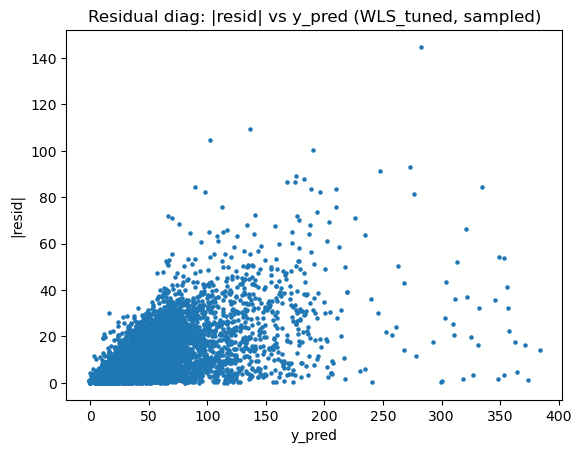

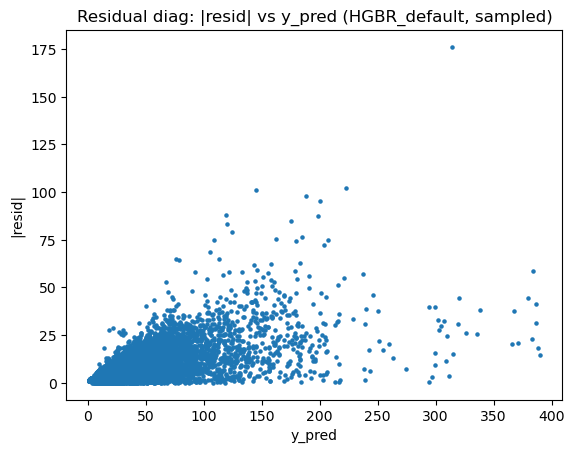

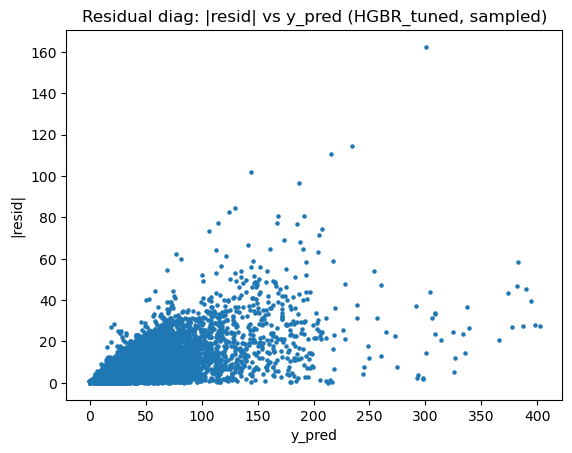

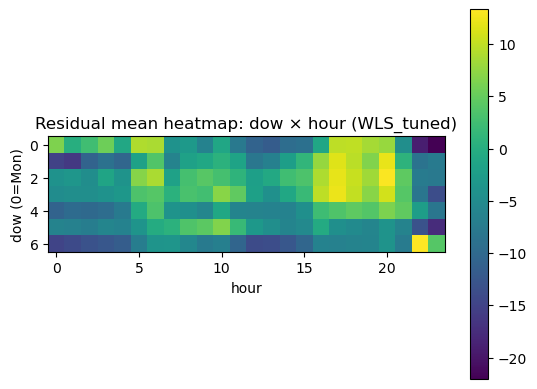

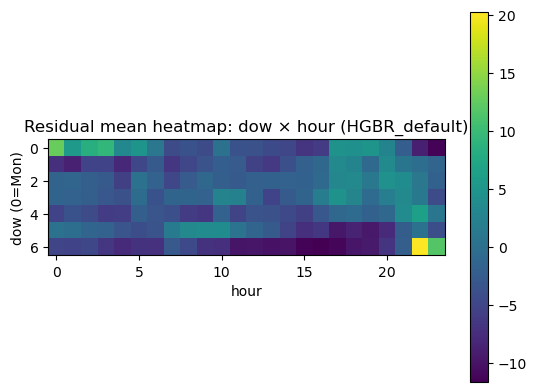

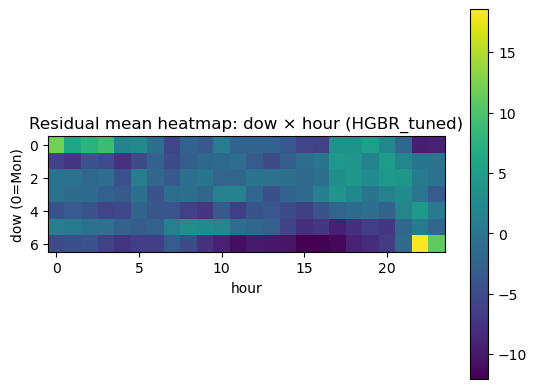

In [23]:
ml_diag = MLResidualDiagnostics(expC, setting_name="C (B + lag/rolling)", wls_clip=(0.001, 0.999))
summary_d, diag_df_d = ml_diag.run(
    model_names=["WLS_tuned", "HGBR_default", "HGBR_tuned"],
    do_plots=True
)

## 预测能力

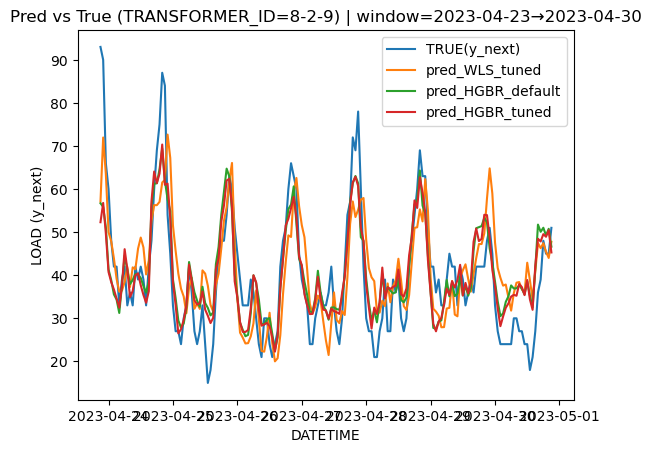

Plotted TRANSFORMER_ID: 8-2-9 | window: 2023-04-23 21:00:00 -> 2023-04-30 21:00:00


In [24]:
def plot_pred_vs_true_timeseries(
    diag_df,
    transformer_id=None,
    days=7,
    start=None,
    models=("WLS_tuned", "HGBR_default", "HGBR_tuned"),
):
    df = diag_df.copy()
    df["DATETIME"] = pd.to_datetime(df["DATETIME"])
    df = df.sort_values(["TRANSFORMER_ID", "DATETIME"])

    if transformer_id is None:
        transformer_id = df["TRANSFORMER_ID"].value_counts().idxmax()

    sub = df[df["TRANSFORMER_ID"] == transformer_id].copy()
    sub = sub.sort_values("DATETIME")

    if start is not None:
        start_ts = pd.to_datetime(start)
        end_ts = start_ts + pd.Timedelta(days=days)
        sub = sub[(sub["DATETIME"] >= start_ts) & (sub["DATETIME"] < end_ts)].copy()
    else:
        if len(sub) == 0:
            raise ValueError("Selected transformer has no rows in diag_df.")
        end_ts = sub["DATETIME"].max()
        start_ts = end_ts - pd.Timedelta(days=days)
        sub = sub[sub["DATETIME"] >= start_ts].copy()

    fig, ax = plt.subplots()
    ax.plot(sub["DATETIME"], sub["y_next"], label="TRUE(y_next)")

    for m in models:
        col = f"pred_{m}"
        if col not in sub.columns:
            raise KeyError(f"Missing column in diag_df: {col}")
        ax.plot(sub["DATETIME"], sub[col], label=col)

    ax.set_title(f"Pred vs True (TRANSFORMER_ID={transformer_id}) | window={start_ts.date()}→{end_ts.date()}")
    ax.set_xlabel("DATETIME")
    ax.set_ylabel("LOAD (y_next)")
    ax.legend()
    plt.show()

    return transformer_id, start_ts, end_ts


tid, s, e = plot_pred_vs_true_timeseries(diag_df_d, days=7)
print("Plotted TRANSFORMER_ID:", tid, "| window:", s, "->", e)

In [25]:
results_pack = {
    "leader_C": leader_C,
    "D_baseline": d_out["baseline"],
    "D_best": d_out["best"],
    "D_tune_hgbr": d_out["tune_hgbr"],
    "D_tune_mlp": d_out["tune_mlp"],
    "D_resid_summary": summary_d,     # 你残差诊断跑出来的 summary
}

# 可选：保存为 csv，方便放附录
leader_C.to_csv("leader_C.csv", index=False)
summary_d.to_csv("D_residual_summary.csv", index=False)
d_out["tune_hgbr"].to_csv("D_tune_hgbr.csv", index=False)
d_out["tune_mlp"].to_csv("D_tune_mlp.csv", index=False)

## 跨年泛化验证（Out-year）

本节固定特征工程与建模流程不变，将训练窗口切换到上一年度同期，以检验模型在跨年分布变化下的稳定性。
- 训练：2022 同期窗口  
- 测试：2023 主窗口  
说明：跨年实验对特征的“对齐一致性”（类别 one-hot、缺失填补统计量、尺度变换等）要求更高，故实现中显式处理 common transformer 集合与统一的预处理流程。


In [26]:
# 说明：为保证 Notebook 可复现与依赖最小化，这里显式封装 RMSE/MAE 等小工具函数，
# 便于在不同实验模块之间复用并保持指标口径一致。

# 需要注意，进行泛化验证的过程中，很容易报错的一点是内存问题

[INFO] One-month Xtr shape=(109448, 302) | size≈126.1 MB | #cat=281

===== One-month Cross-year Generalization Leaderboard (Train=2022, Test=2023) =====
                           Model  InYear_2022_TEST_RMSE  InYear_2022_TEST_MAE  \
0              Ridge(alpha=0.01)               9.259760              6.355225   
1              HGBR(best_params)              43.165694             41.258727   
2  WLS(FGLS,clip=(0.001, 0.999))              61.786213             47.011322   
3               MLP(best_params)             508.443658            506.336334   

   OutYear_2023_TEST_RMSE  OutYear_2023_TEST_MAE  
0               11.417946               7.501776  
1               41.619723              39.621487  
2               65.985405              51.637268  
3              487.878683             484.956451  


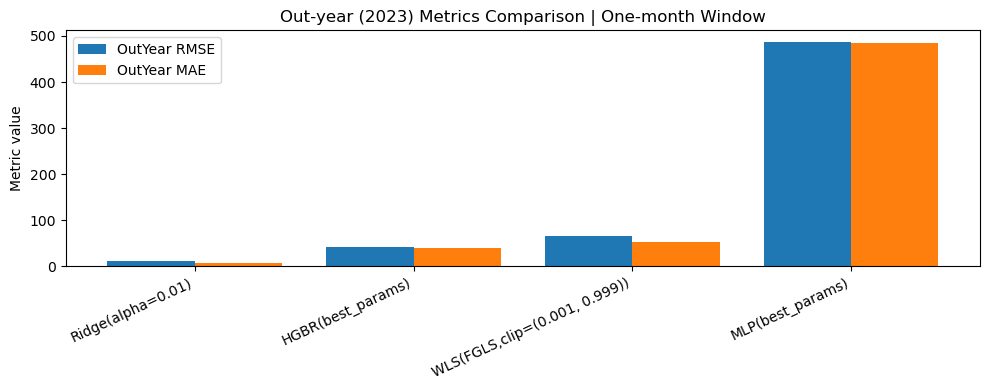

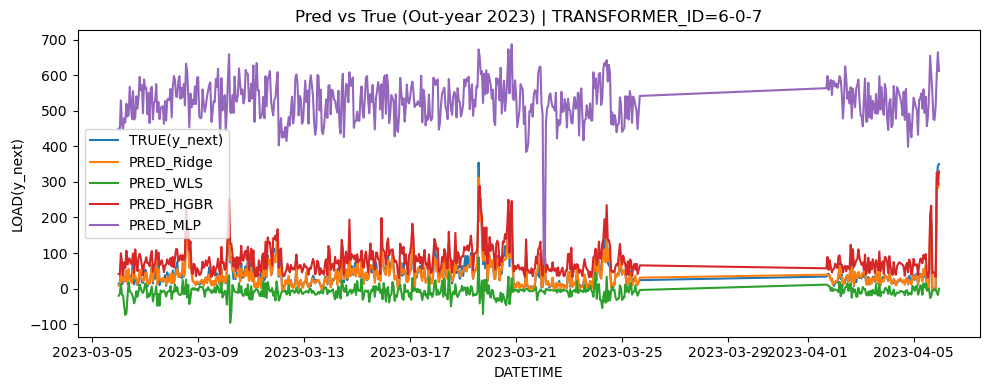

[PLOT] TRANSFORMER_ID=6-0-7 | n=575

[Done] One-month cross-year generalization finished.


In [27]:
def RMSE(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def MAE(y, p):  return float(mean_absolute_error(y, p))

def _to_f32(a):
    a = np.asarray(a)
    if a.dtype != np.float32:
        a = a.astype(np.float32, copy=False)
    return np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)

class Float32Standardizer:
    """
    float32 标准化，避免 float64 内存爆炸
    """
    def __init__(self, eps=1e-8):
        self.mean_ = None
        self.std_  = None
        self.eps   = float(eps)

    def fit(self, X):
        X = _to_f32(X)
        self.mean_ = X.mean(axis=0, dtype=np.float32)
        self.std_  = X.std(axis=0, dtype=np.float32)
        self.std_  = np.where(self.std_ < self.eps, 1.0, self.std_).astype(np.float32, copy=False)
        return self

    def transform(self, X):
        X = _to_f32(X)
        return ((X - self.mean_) / (self.std_ + self.eps)).astype(np.float32, copy=False)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

def _must_get(name):
    if name not in globals():
        raise NameError(f"缺少变量 `{name}`。请先运行你前面构建底表/清洗外生变量的代码单元。")
    return globals()[name]

def _get_first_existing(*names):
    for n in names:
        if n in globals():
            return globals()[n]
    raise NameError(f"缺少所需变量（候选：{names}）。请先运行前置数据构建/清洗单元。")


class WLSViaScaling:
    def __init__(self):
        self.intercept_ = 0.0
        self.coef_ = None

    def fit(self, X, y, w):
        X = _to_f32(X)
        y = _to_f32(y).reshape(-1)
        w = _to_f32(w).reshape(-1)

        w = np.clip(w, 0.0, np.finfo(np.float32).max)
        sw = np.sqrt(w).astype(np.float32, copy=False)

        Xw = X * sw[:, None]
        yw = y * sw

        # add constant column (equivalent to intercept)
        Xw2 = np.concatenate([sw[:, None], Xw], axis=1)

        lr = LinearRegression(fit_intercept=False, copy_X=False)
        lr.fit(Xw2, yw)

        coef = lr.coef_.astype(np.float32, copy=False)
        self.intercept_ = float(coef[0])
        self.coef_ = coef[1:]
        return self

    def predict(self, X):
        X = _to_f32(X)
        return self.intercept_ + X.dot(self.coef_)

def _safe_group_var(df_id_resid, id_col="TRANSFORMER_ID", resid_col="resid", eps=1e-6):
    v = df_id_resid.groupby(id_col, observed=False)[resid_col].var()
    gv = np.nanmedian(v.values)
    if (not np.isfinite(gv)) or gv <= 0:
        gv = 1.0
    v = v.fillna(gv).replace(0.0, eps).clip(lower=eps)
    return v.astype(np.float32), float(gv)



def build_id_vocab(train_df, id_col="TRANSFORMER_ID", top_k=300):
    vc = train_df[id_col].astype(str).value_counts()
    return set(vc.head(int(top_k)).index.tolist())

def transform_id(df, keep_set, id_col="TRANSFORMER_ID"):
    s = df[id_col].astype(str)
    return s.where(s.isin(keep_set), other="__OTHER__")

def design_matrix(df, num_cols, id_series, id_categories=None):
    X_num = df[num_cols].to_numpy(dtype=np.float32, copy=False)
    X_num = np.nan_to_num(X_num, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32, copy=False)

    cat = pd.Categorical(id_series.astype(str), categories=id_categories)
    X_cat = pd.get_dummies(cat, prefix="TID", dummy_na=False, dtype=np.float32)

    X = np.concatenate([X_num, X_cat.to_numpy(dtype=np.float32, copy=False)], axis=1).astype(np.float32, copy=False)
    return X, list(cat.categories)



if "RegressionExperimentABC" not in globals():
    raise NameError("缺少类 RegressionExperimentABC。请先运行你前面定义回归实验类的代码单元。")

if "expC_2022" not in globals():
    df_base_2022 = _must_get("df_base_2022")
    weather_2022 = _get_first_existing("weather_clean_2022", "weather_clean")
    ext_2022     = _get_first_existing("ext_clean_2022", "ext_clean")
    expC_2022 = RegressionExperimentABC(df_base_2022, weather_2022, ext_2022)

if "expC_2023" not in globals():
    df_base_2023 = _must_get("df_base_2023")
    weather_2023 = _get_first_existing("weather_clean_2023", "weather_clean")
    ext_2023     = _get_first_existing("ext_clean_2023", "ext_clean")
    expC_2023 = RegressionExperimentABC(df_base_2023, weather_2023, ext_2023)

# 强制：类别特征只使用 TRANSFORMER_ID（避免把 DATETIME 等误 one-hot）
expC_2022.cfg["cat_cols"] = ["TRANSFORMER_ID"]
expC_2023.cfg["cat_cols"] = ["TRANSFORMER_ID"]




def cross_year_generalization_one_month(
    exp22,
    exp23,
    window_2022=("2022-03-06 00:00:00", "2022-04-05 23:00:00"),
    window_2023=("2023-03-06 00:00:00", "2023-04-05 23:00:00"),
    top_k_transformers=300,
    ridge_alpha=0.01,
    wls_clip=(0.001, 0.999),
    hgbr_params=None,
    mlp_params=None,
    random_state=42,
    plot_transformer_id=None,
    plot_max_points=1500
):
    # set windows
    exp22.cfg["window"]["start"], exp22.cfg["window"]["end"] = window_2022
    exp23.cfg["window"]["start"], exp23.cfg["window"]["end"] = window_2023

    # build main dfs
    df22 = exp22.build_df_main()
    df23 = exp23.build_df_main()

    # C-ready & y_next
    need = exp22.cfg.get("lag_cols", []) + exp22.cfg.get("roll_cols", [])
    drop_cols = list(set(need + ["y_next"]))
    df22 = df22.dropna(subset=drop_cols).copy(deep=False)
    df23 = df23.dropna(subset=drop_cols).copy(deep=False)

    common_ids = set(df22["TRANSFORMER_ID"].astype(str)).intersection(set(df23["TRANSFORMER_ID"].astype(str)))
    df22 = df22[df22["TRANSFORMER_ID"].astype(str).isin(common_ids)].copy(deep=False)
    df23 = df23[df23["TRANSFORMER_ID"].astype(str).isin(common_ids)].copy(deep=False)

    tr22, va22, te22 = exp22.time_split_701515(df22)
    tr2,  va2,  te2, exog_used = exp22.prepare_exog(tr22, va22, te22)


    _, _, te23, _ = exp22.prepare_exog(tr22, va22, df23)

    train_final = pd.concat([tr2, va2], axis=0).reset_index(drop=True)

    time_cols = exp22.cfg.get("time_cols", ["hour", "dow", "month", "hour_sin", "hour_cos"])
    lag_cols  = exp22.cfg.get("lag_cols", [])
    roll_cols = exp22.cfg.get("roll_cols", [])
    num_cols  = list(exog_used) + list(time_cols) + list(lag_cols) + list(roll_cols)

    keep_set = build_id_vocab(train_final, "TRANSFORMER_ID", top_k=top_k_transformers)
    id_tr = transform_id(train_final, keep_set)
    id_22 = transform_id(te2, keep_set)
    id_23 = transform_id(te23, keep_set)

    Xtr, categories = design_matrix(train_final, num_cols, id_tr, id_categories=None)
    X22, _          = design_matrix(te2,        num_cols, id_22, id_categories=categories)
    X23, _          = design_matrix(te23,       num_cols, id_23, id_categories=categories)

    ytr = train_final["y_next"].to_numpy(dtype=np.float32, copy=False)
    y22 = te2["y_next"].to_numpy(dtype=np.float32, copy=False)
    y23 = te23["y_next"].to_numpy(dtype=np.float32, copy=False)

    print(f"[INFO] One-month Xtr shape={Xtr.shape} | size≈{Xtr.nbytes/1024/1024:.1f} MB | #cat={len(categories)}")

    # default tuned params (fallback)
    if hgbr_params is None:
        hgbr_params = dict(
            learning_rate=0.1, max_depth=6, max_leaf_nodes=63, min_samples_leaf=20,
            max_iter=200, random_state=random_state
        )
    if mlp_params is None:
        mlp_params = dict(
            hidden_layer_sizes=(128, 64), alpha=0.001, learning_rate_init=0.0005,
            max_iter=200, early_stopping=True, n_iter_no_change=10, tol=1e-4,
            random_state=random_state
        )

    results = []
    preds_23 = {}  # for plotting

    
    std = Float32Standardizer().fit(Xtr)
    Xtr_s = std.transform(Xtr)
    X22_s = std.transform(X22)
    X23_s = std.transform(X23)

    ridge = Ridge(alpha=float(ridge_alpha), solver="sag", max_iter=2000, tol=1e-4, random_state=random_state)
    ridge.fit(Xtr_s, ytr)
    p22 = ridge.predict(X22_s)
    p23 = ridge.predict(X23_s)
    preds_23["Ridge"] = p23

    results.append({
        "Model": f"Ridge(alpha={ridge_alpha})",
        "InYear_2022_TEST_RMSE": RMSE(y22, p22),
        "InYear_2022_TEST_MAE":  MAE(y22, p22),
        "OutYear_2023_TEST_RMSE": RMSE(y23, p23),
        "OutYear_2023_TEST_MAE":  MAE(y23, p23),
    })

    
    ols0 = LinearRegression(copy_X=False)
    ols0.fit(Xtr, ytr)
    resid = (ytr - ols0.predict(Xtr)).astype(np.float32, copy=False)

    tmp = pd.DataFrame({"TRANSFORMER_ID": id_tr.astype(str).values, "resid": resid})
    var_by_id, global_var = _safe_group_var(tmp, "TRANSFORMER_ID", "resid", eps=1e-6)
    var_map = var_by_id.to_dict()

    mapped = pd.Series(id_tr.astype(str).values).map(var_map).astype(np.float32)
    mapped = mapped.fillna(np.float32(global_var))
    w_raw = (1.0 / mapped.values).astype(np.float32, copy=False)
    w_raw = np.nan_to_num(w_raw, nan=0.0, posinf=0.0, neginf=0.0)

    ql, qh = float(wls_clip[0]), float(wls_clip[1])
    lo = float(np.quantile(w_raw, ql)) if ql > 0 else float(np.min(w_raw))
    hi = float(np.quantile(w_raw, qh)) if qh < 1 else float(np.max(w_raw))
    w = np.clip(w_raw, lo, hi).astype(np.float32, copy=False)

    wls = WLSViaScaling().fit(Xtr, ytr, w)
    p22 = wls.predict(X22)
    p23 = wls.predict(X23)
    preds_23["WLS"] = p23

    results.append({
        "Model": f"WLS(FGLS,clip={tuple(wls_clip)})",
        "InYear_2022_TEST_RMSE": RMSE(y22, p22),
        "InYear_2022_TEST_MAE":  MAE(y22, p22),
        "OutYear_2023_TEST_RMSE": RMSE(y23, p23),
        "OutYear_2023_TEST_MAE":  MAE(y23, p23),
    })

    
    hgbr = HistGradientBoostingRegressor(**hgbr_params)
    hgbr.fit(Xtr, ytr)
    p22 = hgbr.predict(X22)
    p23 = hgbr.predict(X23)
    preds_23["HGBR"] = p23

    results.append({
        "Model": "HGBR(best_params)",
        "InYear_2022_TEST_RMSE": RMSE(y22, p22),
        "InYear_2022_TEST_MAE":  MAE(y22, p22),
        "OutYear_2023_TEST_RMSE": RMSE(y23, p23),
        "OutYear_2023_TEST_MAE":  MAE(y23, p23),
    })


    
    std_m = Float32Standardizer().fit(Xtr)
    Xtr_m = std_m.transform(Xtr)
    X22_m = std_m.transform(X22)
    X23_m = std_m.transform(X23)

    mlp = MLPRegressor(**mlp_params)
    mlp.fit(Xtr_m, ytr)
    p22 = mlp.predict(X22_m)
    p23 = mlp.predict(X23_m)
    preds_23["MLP"] = p23

    results.append({
        "Model": "MLP(best_params)",
        "InYear_2022_TEST_RMSE": RMSE(y22, p22),
        "InYear_2022_TEST_MAE":  MAE(y22, p22),
        "OutYear_2023_TEST_RMSE": RMSE(y23, p23),
        "OutYear_2023_TEST_MAE":  MAE(y23, p23),
    })

    leaderboard = pd.DataFrame(results).sort_values("OutYear_2023_TEST_RMSE").reset_index(drop=True)
    print("\n===== One-month Cross-year Generalization Leaderboard (Train=2022, Test=2023) =====")
    print(leaderboard)


    
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(len(leaderboard))
    ax.bar(x - 0.2, leaderboard["OutYear_2023_TEST_RMSE"].values, width=0.4, label="OutYear RMSE")
    ax.bar(x + 0.2, leaderboard["OutYear_2023_TEST_MAE"].values,  width=0.4, label="OutYear MAE")
    ax.set_xticks(x)
    ax.set_xticklabels(leaderboard["Model"].values, rotation=25, ha="right")
    ax.set_title("Out-year (2023) Metrics Comparison | One-month Window")
    ax.set_ylabel("Metric value")
    ax.legend()
    plt.tight_layout()
    plt.show()


    
    te23_plot = te23.sort_values("DATETIME").reset_index(drop=True)
    if plot_transformer_id is None:
        plot_transformer_id = te23_plot["TRANSFORMER_ID"].astype(str).value_counts().index[0]

    mask = (te23_plot["TRANSFORMER_ID"].astype(str) == str(plot_transformer_id))
    if mask.sum() > 0:
        idx = np.where(mask.values)[0]
        tp = te23_plot.loc[te23_plot.index[idx], "DATETIME"].values
        y_true = y23[idx]

        if plot_max_points is not None and len(tp) > int(plot_max_points):
            sel = np.linspace(0, len(tp) - 1, int(plot_max_points)).astype(int)
            tp = tp[sel]
            y_true = y_true[sel]
            idx = idx[sel]

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(tp, y_true, label="TRUE(y_next)")
        ax.plot(tp, preds_23["Ridge"][idx], label="PRED_Ridge")
        ax.plot(tp, preds_23["WLS"][idx],  label="PRED_WLS")
        ax.plot(tp, preds_23["HGBR"][idx], label="PRED_HGBR")
        ax.plot(tp, preds_23["MLP"][idx],  label="PRED_MLP")

        ax.set_title(f"Pred vs True (Out-year 2023) | TRANSFORMER_ID={plot_transformer_id}")
        ax.set_xlabel("DATETIME")
        ax.set_ylabel("LOAD(y_next)")
        ax.legend()
        plt.tight_layout()
        plt.show()

        print(f"[PLOT] TRANSFORMER_ID={plot_transformer_id} | n={len(tp)}")
    else:
        print("[PLOT] 2023 测试集中找不到指定 TRANSFORMER_ID，跳过预测对比图。")

    gc.collect()
    return leaderboard




best_alpha = globals().get("best_alpha_2022", globals().get("best_alpha_2023", 0.01))
best_clip  = globals().get("best_clip_2022",  globals().get("best_clip_2023", (0.001, 0.999)))

hgbr_best = globals().get(
    "best_hgbr_params",
    dict(learning_rate=0.1, max_depth=6, max_leaf_nodes=63, min_samples_leaf=20, max_iter=200, random_state=42)
)
mlp_best = globals().get(
    "best_mlp_params",
    dict(hidden_layer_sizes=(128, 64), alpha=0.001, learning_rate_init=0.0005,
         max_iter=200, early_stopping=True, n_iter_no_change=10, tol=1e-4, random_state=42)
)



leaderboard_oneyear = cross_year_generalization_one_month(
    expC_2022,
    expC_2023,
    window_2022=("2022-03-06 00:00:00", "2022-04-05 23:00:00"),
    window_2023=("2023-03-06 00:00:00", "2023-04-05 23:00:00"),
    top_k_transformers=300,          # 内存紧就改成 200
    ridge_alpha=float(best_alpha),
    wls_clip=tuple(best_clip),
    hgbr_params=hgbr_best,
    mlp_params=mlp_best,
    random_state=42,
    plot_transformer_id=None,
    plot_max_points=1500
)

print("\n[Done] One-month cross-year generalization finished.")